<a href="https://colab.research.google.com/github/ppiont/cnn-soc-wagga/blob/master/mlp_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install scikit-optimize

     |████████████████████████████████| 102kB 4.2MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive/')
%cd "/content/drive/MyDrive/Thesis/cnn-soc-wagga"

Mounted at /content/drive/
/content/drive/MyDrive/Thesis/cnn-soc-wagga


In [3]:
# Standard lib imports
import os
import pathlib
import random

# Imports
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from skopt import gp_minimize, dump, load
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_objective, plot_convergence, plot_evaluations
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import copy
import pdb  # Brug det

In [4]:
# ------------------- TO DO ------------------------------------------------- #

"""
Use Torch Dataset.. you made a class for it dummy
"""

# ------------------- Settings ---------------------------------------------- #


# Set matploblib style
plt.style.use('seaborn-colorblind')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.dpi'] = 450
plt.rcParams['savefig.transparent'] = True
plt.rcParams['savefig.format'] = 'svg'

# Reset params if needed
# plt.rcParams.update(mpl.rcParamsDefault)


# ------------------- Organization ------------------------------------------ #


DATA_DIR = pathlib.Path('data/')


def seed_everything(SEED=43):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    os.environ['PYTHONHASHSEED']=str(SEED)
    torch.backends.cudnn.benchmark = False


SEED = 43
seed_everything(SEED=SEED)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [5]:
# ------------------- Read and prep data ------------------------------------ #

train_data = np.load(DATA_DIR.joinpath('train_no_log.npy'))
test_data = np.load(DATA_DIR.joinpath('test_no_log.npy'))

x_train = train_data[:, 1:]
y_train = train_data[:, 0]

input_dims=x_train.shape[-1]

x_test = test_data[:, 1:]
y_test = test_data[:, 0]

# Normalize X
scaler_x = MinMaxScaler()
scaler_x.fit(x_train)
x_train = scaler_x.transform(x_train)
x_test = scaler_x.transform(x_test)

# Normalize y
scaler_y = MinMaxScaler()
scaler_y.fit(y_train.reshape(-1, 1))
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
# There is no reason to scale y_test actually
y_test = scaler_y.transform(y_test.reshape(-1, 1))


x_train, y_train = torch.from_numpy(x_train), torch.from_numpy(y_train)
x_test, y_test = torch.from_numpy(x_test), torch.from_numpy(y_test)

x_train, x_test = x_train.to(device), x_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

class Dataset(torch.utils.data.TensorDataset):
    """Characterize a PyTorch Dataset."""

    def __init__(self, features, targets):
        """Initialize with X and y."""
        self.features = features
        self.targets = targets

    def __len__(self):
        """Return total number of samples."""
        return len(self.targets)

    def __getitem__(self, index):
        """Generate one data sample."""
        return self.features[index], self.targets[index]

In [6]:
# ------------------- NN setup ---------------------------------------------- #

class NeuralNet(nn.Module):
    """Neural Network class."""

    def __init__(self, input_dims=input_dims, n_layers=3, n_neurons=64,
                 activation=nn.ELU(), dropout_rate=0.5):
        """Initialize as subclass of nn.Module, inherit its methods."""
        super(NeuralNet, self).__init__()

        self.input_dims = input_dims
        self.n_neurons = n_neurons
        self.n_layers = n_layers

        # Layer structure
        # First layer
        self.in_layer = nn.Linear(self.input_dims, self.n_neurons)

        # Dense, Dropout, Activation and BN
        self.dense = nn.Linear(self.n_neurons, self.n_neurons)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.activation = activation
        self.batchnorm = nn.BatchNorm1d(self.n_neurons)

        # Output layer
        self.out_layer = nn.Linear(self.n_neurons, 1)

    def forward(self, x):
        """Forward pass."""
                
        x = self.batchnorm(self.activation(self.dropout(self.in_layer(x))))

        for i in range(self.n_layers-1):
            x = self.batchnorm(self.activation(self.dropout(self.dense(x))))

        x = self.out_layer(x)

        return x


def train_step(model, features, targets, optimizer, loss_fn):
    """Perform a single training step.

    Calulcates prediction, loss and gradients for a single batch
    and updates optimizer parameters accordingly."""

    # Set gradients to zero
    model.zero_grad()
    # Pass data through model
    output = model(features)
    # Calculate loss
    loss = loss_fn(output, targets)
    # Calculate gradients
    loss.backward()
    # Update parameters
    optimizer.step()

    return loss, output


def train_network(model, train_data, val_data, optimizer, loss_fn,
                  n_epochs=2000, patience=100, print_progress=True):
    """Train a neural network model."""
    # Initalize loss as very high
    best_loss = 1e8

    # Create lists to hold train and val losses
    train_loss = []
    val_loss = []
    # Init epochs_no_improve
    epochs_no_improve = 0
    best_model = copy.deepcopy(model.state_dict())
    
    # Start training (loop over epochs)
    for epoch in range(n_epochs):

        # Initalize epoch train loss
        train_epoch_loss = 0
        # Loop over training batches
        model.train()  # set model to training mode for training
        for bidx, (features, targets) in enumerate(train_data):
            # Calculate loss and predictions
            loss, predictions = train_step(model, features, targets,
                                           optimizer, loss_fn)
            train_epoch_loss += loss
        # Save train epoch loss
        train_loss.append(train_epoch_loss.item())

        # Initialize val epoch loss
        val_epoch_loss = 0
        # Loop over validation batches
        model.eval()  # set model to evaluation mode for validation
        for bidx, (features, targets) in enumerate(val_data):
            output = model(features)
            val_epoch_loss += loss_fn(output, targets)
        # Save val epoch loss
        val_loss.append(val_epoch_loss.item())

        # Early stopping (check if val loss is an improvement on current best)
        if val_epoch_loss < best_loss:
            best_loss = val_epoch_loss.item()
            best_model = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

            # Check early stopping condition
            if epochs_no_improve == patience:
                print(f'Stopping after {epoch} epochs due to no improvement.')
                model.load_state_dict(best_model)
                break
        # Print progress at set epoch intervals if desired
        if print_progress:
            if (epoch + 1) % 100 == 0:
                print(f'Epoch {epoch+1} Train Loss: {train_epoch_loss:.4}, ', end='')
                print(f'Val Loss: {val_epoch_loss:.4}')

    return train_loss, val_loss


def weight_reset(m):
    """Reset all weights in an NN."""
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()

In [7]:
# ------------------- Cross-validation -------------------------------------- #

def kfold_cv_train(x_train, y_train, model, optimizer,loss_fn=nn.MSELoss(), 
                   n_splits=5, batch_size=312, n_epochs=2000, patience=100,
                   shuffle=True, rng=SEED):
    """Train a NN with K-Fold cross-validation."""
    kfold = KFold(n_splits=n_splits, shuffle=shuffle, random_state=rng)
    best_losses = []

    for fold, (train_index, val_index) in enumerate(kfold.split(x_train, y_train)):
        # print(f'Starting fold {fold + 1}')
        # Get training and val features
        x_train_fold = x_train[train_index]
        x_val_fold = x_train[val_index]

        # Get training and val targets
        y_train_fold = y_train[train_index]
        y_val_fold = y_train[val_index]

        train = Dataset(x_train_fold, y_train_fold)
        train_loader = DataLoader(train, batch_size=batch_size,
                                  shuffle=shuffle, drop_last=True)
        # Create val dataset and dataloader
        val = Dataset(x_val_fold, y_val_fold)
        val_loader = DataLoader(val, batch_size=batch_size,
                                shuffle=False, drop_last=False)

        # Train
        train_loss, val_loss = train_network(model=model,
                                             train_data=train_loader,
                                             val_data=val_loader,
                                             optimizer=optimizer,
                                             loss_fn=loss_fn,
                                             n_epochs=n_epochs,
                                             patience=patience,
                                             print_progress=False)
        best_losses.append(min(val_loss))
        model.apply(weight_reset)

    return sum(best_losses)/n_splits, train_loss, val_loss



Gaussian Process:   0%|          | 0/200 [00:00<?, ?it/s]

Iteration No: 1 started. Evaluating function at provided point.
Stopping after 185 epochs due to no improvement.
Stopping after 190 epochs due to no improvement.
Stopping after 192 epochs due to no improvement.
Stopping after 78 epochs due to no improvement.




Gaussian Process:   0%|          | 1/200 [00:29<1:36:23, 29.06s/it]

Stopping after 103 epochs due to no improvement.
Iteration No: 1 ended. Evaluation done at provided point.
Time taken: 29.0464
Function value obtained: 0.0229
Current minimum: 0.0229
Iteration No: 2 started. Evaluating function at random point.
Stopping after 145 epochs due to no improvement.
Stopping after 197 epochs due to no improvement.
Stopping after 91 epochs due to no improvement.
Stopping after 131 epochs due to no improvement.




Gaussian Process:   1%|          | 2/200 [00:48<1:26:25, 26.19s/it]

Stopping after 166 epochs due to no improvement.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 19.4840
Function value obtained: 0.0133
Current minimum: 0.0133
Iteration No: 3 started. Evaluating function at random point.
Stopping after 64 epochs due to no improvement.
Stopping after 97 epochs due to no improvement.
Stopping after 60 epochs due to no improvement.
Stopping after 81 epochs due to no improvement.




Gaussian Process:   2%|▏         | 3/200 [01:30<1:41:31, 30.92s/it]

Stopping after 74 epochs due to no improvement.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 41.9730
Function value obtained: 0.0612
Current minimum: 0.0133
Iteration No: 4 started. Evaluating function at random point.
Stopping after 98 epochs due to no improvement.
Stopping after 132 epochs due to no improvement.
Stopping after 58 epochs due to no improvement.
Stopping after 192 epochs due to no improvement.




Gaussian Process:   2%|▏         | 4/200 [02:12<1:51:25, 34.11s/it]

Stopping after 179 epochs due to no improvement.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 41.5462
Function value obtained: 0.0383
Current minimum: 0.0133
Iteration No: 5 started. Evaluating function at random point.
Stopping after 107 epochs due to no improvement.
Stopping after 225 epochs due to no improvement.
Stopping after 75 epochs due to no improvement.
Stopping after 112 epochs due to no improvement.




Gaussian Process:   2%|▎         | 5/200 [02:56<2:00:58, 37.22s/it]

Stopping after 94 epochs due to no improvement.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 44.4853
Function value obtained: 0.0420
Current minimum: 0.0133
Iteration No: 6 started. Evaluating function at random point.
Stopping after 256 epochs due to no improvement.
Stopping after 114 epochs due to no improvement.
Stopping after 273 epochs due to no improvement.
Stopping after 94 epochs due to no improvement.




Gaussian Process:   3%|▎         | 6/200 [03:27<1:54:08, 35.30s/it]

Stopping after 134 epochs due to no improvement.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 30.8089
Function value obtained: 0.0183
Current minimum: 0.0133
Iteration No: 7 started. Evaluating function at random point.
Stopping after 64 epochs due to no improvement.
Stopping after 193 epochs due to no improvement.
Stopping after 164 epochs due to no improvement.
Stopping after 72 epochs due to no improvement.




Gaussian Process:   4%|▎         | 7/200 [03:43<1:34:52, 29.50s/it]

Stopping after 140 epochs due to no improvement.
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 15.9561
Function value obtained: 0.0163
Current minimum: 0.0133
Iteration No: 8 started. Evaluating function at random point.
Stopping after 55 epochs due to no improvement.
Stopping after 85 epochs due to no improvement.
Stopping after 93 epochs due to no improvement.
Stopping after 88 epochs due to no improvement.




Gaussian Process:   4%|▍         | 8/200 [03:56<1:18:53, 24.65s/it]

Stopping after 160 epochs due to no improvement.
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 13.3591
Function value obtained: 0.0204
Current minimum: 0.0133
Iteration No: 9 started. Evaluating function at random point.
Stopping after 94 epochs due to no improvement.
Stopping after 110 epochs due to no improvement.
Stopping after 69 epochs due to no improvement.
Stopping after 243 epochs due to no improvement.




Gaussian Process:   4%|▍         | 9/200 [04:11<1:09:09, 21.72s/it]

Stopping after 106 epochs due to no improvement.
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 14.8817
Function value obtained: 0.0147
Current minimum: 0.0133
Iteration No: 10 started. Evaluating function at random point.
Stopping after 126 epochs due to no improvement.
Stopping after 66 epochs due to no improvement.
Stopping after 73 epochs due to no improvement.
Stopping after 182 epochs due to no improvement.




Gaussian Process:   5%|▌         | 10/200 [04:28<1:04:11, 20.27s/it]

Stopping after 76 epochs due to no improvement.
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 16.8852
Function value obtained: 0.0171
Current minimum: 0.0133
Iteration No: 11 started. Evaluating function at random point.
Stopping after 63 epochs due to no improvement.
Stopping after 112 epochs due to no improvement.
Stopping after 128 epochs due to no improvement.
Stopping after 105 epochs due to no improvement.
Stopping after 56 epochs due to no improvement.




Gaussian Process:   6%|▌         | 11/200 [04:57<1:12:11, 22.92s/it]

Iteration No: 11 ended. Evaluation done at random point.
Time taken: 29.0932
Function value obtained: 0.0341
Current minimum: 0.0133
Iteration No: 12 started. Evaluating function at random point.
Stopping after 52 epochs due to no improvement.
Stopping after 50 epochs due to no improvement.
Stopping after 82 epochs due to no improvement.
Stopping after 53 epochs due to no improvement.
Stopping after 179 epochs due to no improvement.




Gaussian Process:   6%|▌         | 12/200 [05:06<58:51, 18.79s/it]  

Iteration No: 12 ended. Evaluation done at random point.
Time taken: 9.1448
Function value obtained: 0.0451
Current minimum: 0.0133
Iteration No: 13 started. Searching for the next optimal point.
Stopping after 62 epochs due to no improvement.
Stopping after 50 epochs due to no improvement.
Stopping after 50 epochs due to no improvement.
Stopping after 51 epochs due to no improvement.
Stopping after 50 epochs due to no improvement.




Gaussian Process:   6%|▋         | 13/200 [05:14<48:12, 15.47s/it]

Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 7.7231
Function value obtained: 0.0340
Current minimum: 0.0133
Iteration No: 14 started. Searching for the next optimal point.
Stopping after 802 epochs due to no improvement.
Stopping after 50 epochs due to no improvement.
Stopping after 52 epochs due to no improvement.
Stopping after 53 epochs due to no improvement.
Stopping after 53 epochs due to no improvement.




Gaussian Process:   7%|▋         | 14/200 [05:37<54:46, 17.67s/it]

Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 22.8101
Function value obtained: 0.0281
Current minimum: 0.0133
Iteration No: 15 started. Searching for the next optimal point.
Stopping after 151 epochs due to no improvement.
Stopping after 89 epochs due to no improvement.
Stopping after 213 epochs due to no improvement.
Stopping after 211 epochs due to no improvement.
Stopping after 153 epochs due to no improvement.




Gaussian Process:   8%|▊         | 15/200 [06:00<59:50, 19.41s/it]

Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 23.4700
Function value obtained: 0.0189
Current minimum: 0.0133
Iteration No: 16 started. Searching for the next optimal point.
Stopping after 57 epochs due to no improvement.
Stopping after 159 epochs due to no improvement.
Stopping after 363 epochs due to no improvement.
Stopping after 70 epochs due to no improvement.
Stopping after 59 epochs due to no improvement.




Gaussian Process:   8%|▊         | 16/200 [06:17<56:56, 18.57s/it]

Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 16.5921
Function value obtained: 0.0627
Current minimum: 0.0133
Iteration No: 17 started. Searching for the next optimal point.
Stopping after 50 epochs due to no improvement.
Stopping after 50 epochs due to no improvement.
Stopping after 50 epochs due to no improvement.
Stopping after 187 epochs due to no improvement.
Stopping after 50 epochs due to no improvement.




Gaussian Process:   8%|▊         | 17/200 [06:28<50:04, 16.42s/it]

Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 11.4177
Function value obtained: 0.1694
Current minimum: 0.0133
Iteration No: 18 started. Searching for the next optimal point.
Stopping after 214 epochs due to no improvement.
Stopping after 173 epochs due to no improvement.
Stopping after 568 epochs due to no improvement.
Stopping after 232 epochs due to no improvement.
Stopping after 189 epochs due to no improvement.




Gaussian Process:   9%|▉         | 18/200 [07:08<1:11:15, 23.49s/it]

Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 39.9893
Function value obtained: 0.0124
Current minimum: 0.0124
Iteration No: 19 started. Searching for the next optimal point.
Stopping after 202 epochs due to no improvement.
Stopping after 172 epochs due to no improvement.
Stopping after 173 epochs due to no improvement.
Stopping after 89 epochs due to no improvement.
Stopping after 99 epochs due to no improvement.




Gaussian Process:  10%|▉         | 19/200 [09:12<2:41:49, 53.64s/it]

Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 123.9900
Function value obtained: 0.0937
Current minimum: 0.0124
Iteration No: 20 started. Searching for the next optimal point.
Stopping after 102 epochs due to no improvement.
Stopping after 76 epochs due to no improvement.
Stopping after 70 epochs due to no improvement.
Stopping after 67 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.




Gaussian Process:  10%|█         | 20/200 [09:25<2:03:47, 41.26s/it]

Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 12.3833
Function value obtained: 0.0091
Current minimum: 0.0091
Iteration No: 21 started. Searching for the next optimal point.
Stopping after 59 epochs due to no improvement.
Stopping after 65 epochs due to no improvement.
Stopping after 75 epochs due to no improvement.
Stopping after 93 epochs due to no improvement.
Stopping after 83 epochs due to no improvement.




Gaussian Process:  10%|█         | 21/200 [10:32<2:26:32, 49.12s/it]

Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 67.4469
Function value obtained: 0.0844
Current minimum: 0.0091
Iteration No: 22 started. Searching for the next optimal point.
Stopping after 231 epochs due to no improvement.
Stopping after 149 epochs due to no improvement.
Stopping after 170 epochs due to no improvement.
Stopping after 549 epochs due to no improvement.
Stopping after 127 epochs due to no improvement.




Gaussian Process:  11%|█         | 22/200 [11:07<2:13:09, 44.88s/it]

Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 35.0021
Function value obtained: 0.0113
Current minimum: 0.0091
Iteration No: 23 started. Searching for the next optimal point.
Stopping after 61 epochs due to no improvement.
Stopping after 128 epochs due to no improvement.
Stopping after 88 epochs due to no improvement.
Stopping after 501 epochs due to no improvement.
Stopping after 320 epochs due to no improvement.




Gaussian Process:  12%|█▏        | 23/200 [11:37<1:59:18, 40.44s/it]

Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 30.0765
Function value obtained: 0.0823
Current minimum: 0.0091
Iteration No: 24 started. Searching for the next optimal point.
Stopping after 75 epochs due to no improvement.
Stopping after 106 epochs due to no improvement.
Stopping after 64 epochs due to no improvement.
Stopping after 110 epochs due to no improvement.
Stopping after 78 epochs due to no improvement.




Gaussian Process:  12%|█▏        | 24/200 [12:18<1:58:47, 40.50s/it]

Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 40.6217
Function value obtained: 0.0703
Current minimum: 0.0091
Iteration No: 25 started. Searching for the next optimal point.
Stopping after 103 epochs due to no improvement.
Stopping after 171 epochs due to no improvement.
Stopping after 145 epochs due to no improvement.
Stopping after 121 epochs due to no improvement.
Stopping after 165 epochs due to no improvement.




Gaussian Process:  12%|█▎        | 25/200 [13:24<2:20:31, 48.18s/it]

Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 66.1029
Function value obtained: 0.0828
Current minimum: 0.0091
Iteration No: 26 started. Searching for the next optimal point.
Stopping after 65 epochs due to no improvement.
Stopping after 93 epochs due to no improvement.
Stopping after 113 epochs due to no improvement.
Stopping after 61 epochs due to no improvement.
Stopping after 159 epochs due to no improvement.




Gaussian Process:  13%|█▎        | 26/200 [13:38<1:50:26, 38.08s/it]

Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 14.5275
Function value obtained: 0.0090
Current minimum: 0.0090
Iteration No: 27 started. Searching for the next optimal point.
Stopping after 136 epochs due to no improvement.
Stopping after 115 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.
Stopping after 137 epochs due to no improvement.
Stopping after 123 epochs due to no improvement.




Gaussian Process:  14%|█▎        | 27/200 [13:56<1:32:33, 32.10s/it]

Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 18.1402
Function value obtained: 0.0092
Current minimum: 0.0090
Iteration No: 28 started. Searching for the next optimal point.
Stopping after 55 epochs due to no improvement.
Stopping after 68 epochs due to no improvement.
Stopping after 180 epochs due to no improvement.
Stopping after 131 epochs due to no improvement.
Stopping after 88 epochs due to no improvement.




Gaussian Process:  14%|█▍        | 28/200 [14:44<1:45:41, 36.87s/it]

Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 47.9937
Function value obtained: 0.0722
Current minimum: 0.0090
Iteration No: 29 started. Searching for the next optimal point.
Stopping after 75 epochs due to no improvement.
Stopping after 66 epochs due to no improvement.
Stopping after 86 epochs due to no improvement.
Stopping after 59 epochs due to no improvement.
Stopping after 70 epochs due to no improvement.




Gaussian Process:  14%|█▍        | 29/200 [14:56<1:23:22, 29.26s/it]

Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 11.4966
Function value obtained: 0.0181
Current minimum: 0.0090
Iteration No: 30 started. Searching for the next optimal point.
Stopping after 51 epochs due to no improvement.
Stopping after 402 epochs due to no improvement.
Stopping after 275 epochs due to no improvement.
Stopping after 50 epochs due to no improvement.
Stopping after 50 epochs due to no improvement.




Gaussian Process:  15%|█▌        | 30/200 [15:20<1:18:11, 27.60s/it]

Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 23.7214
Function value obtained: 0.0136
Current minimum: 0.0090
Iteration No: 31 started. Searching for the next optimal point.
Stopping after 180 epochs due to no improvement.
Stopping after 66 epochs due to no improvement.
Stopping after 168 epochs due to no improvement.
Stopping after 73 epochs due to no improvement.
Stopping after 170 epochs due to no improvement.




Gaussian Process:  16%|█▌        | 31/200 [15:34<1:06:25, 23.59s/it]

Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 14.2255
Function value obtained: 0.0078
Current minimum: 0.0078
Iteration No: 32 started. Searching for the next optimal point.
Stopping after 195 epochs due to no improvement.
Stopping after 67 epochs due to no improvement.
Stopping after 75 epochs due to no improvement.
Stopping after 79 epochs due to no improvement.
Stopping after 168 epochs due to no improvement.




Gaussian Process:  16%|█▌        | 32/200 [15:48<57:57, 20.70s/it]  

Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 13.9658
Function value obtained: 0.0150
Current minimum: 0.0078
Iteration No: 33 started. Searching for the next optimal point.
Stopping after 187 epochs due to no improvement.
Stopping after 106 epochs due to no improvement.
Stopping after 95 epochs due to no improvement.
Stopping after 170 epochs due to no improvement.
Stopping after 79 epochs due to no improvement.




Gaussian Process:  16%|█▋        | 33/200 [16:09<57:56, 20.82s/it]

Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 21.0870
Function value obtained: 0.0170
Current minimum: 0.0078
Iteration No: 34 started. Searching for the next optimal point.
Stopping after 167 epochs due to no improvement.
Stopping after 378 epochs due to no improvement.
Stopping after 95 epochs due to no improvement.
Stopping after 80 epochs due to no improvement.
Stopping after 73 epochs due to no improvement.




Gaussian Process:  17%|█▋        | 34/200 [16:30<57:48, 20.89s/it]

Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 21.0645
Function value obtained: 0.0162
Current minimum: 0.0078
Iteration No: 35 started. Searching for the next optimal point.
Stopping after 147 epochs due to no improvement.
Stopping after 114 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 70 epochs due to no improvement.
Stopping after 61 epochs due to no improvement.




Gaussian Process:  18%|█▊        | 35/200 [16:45<52:28, 19.08s/it]

Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 14.8563
Function value obtained: 0.0092
Current minimum: 0.0078
Iteration No: 36 started. Searching for the next optimal point.
Stopping after 78 epochs due to no improvement.
Stopping after 80 epochs due to no improvement.
Stopping after 81 epochs due to no improvement.
Stopping after 78 epochs due to no improvement.
Stopping after 93 epochs due to no improvement.




Gaussian Process:  18%|█▊        | 36/200 [16:57<46:42, 17.09s/it]

Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 12.4467
Function value obtained: 0.0092
Current minimum: 0.0078
Iteration No: 37 started. Searching for the next optimal point.
Stopping after 282 epochs due to no improvement.
Stopping after 130 epochs due to no improvement.
Stopping after 140 epochs due to no improvement.
Stopping after 80 epochs due to no improvement.
Stopping after 73 epochs due to no improvement.




Gaussian Process:  18%|█▊        | 37/200 [17:13<45:20, 16.69s/it]

Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 15.7624
Function value obtained: 0.0075
Current minimum: 0.0075
Iteration No: 38 started. Searching for the next optimal point.
Stopping after 83 epochs due to no improvement.
Stopping after 57 epochs due to no improvement.
Stopping after 59 epochs due to no improvement.
Stopping after 108 epochs due to no improvement.
Stopping after 107 epochs due to no improvement.




Gaussian Process:  19%|█▉        | 38/200 [17:26<42:05, 15.59s/it]

Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 13.0136
Function value obtained: 0.0091
Current minimum: 0.0075
Iteration No: 39 started. Searching for the next optimal point.
Stopping after 115 epochs due to no improvement.
Stopping after 89 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.
Stopping after 83 epochs due to no improvement.
Stopping after 94 epochs due to no improvement.




Gaussian Process:  20%|█▉        | 39/200 [17:43<42:47, 15.95s/it]

Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 16.7873
Function value obtained: 0.0171
Current minimum: 0.0075
Iteration No: 40 started. Searching for the next optimal point.
Stopping after 149 epochs due to no improvement.
Stopping after 201 epochs due to no improvement.
Stopping after 200 epochs due to no improvement.
Stopping after 165 epochs due to no improvement.
Stopping after 160 epochs due to no improvement.




Gaussian Process:  20%|██        | 40/200 [18:03<45:30, 17.06s/it]

Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 19.6656
Function value obtained: 0.0123
Current minimum: 0.0075
Iteration No: 41 started. Searching for the next optimal point.
Stopping after 117 epochs due to no improvement.
Stopping after 229 epochs due to no improvement.
Stopping after 87 epochs due to no improvement.
Stopping after 201 epochs due to no improvement.
Stopping after 187 epochs due to no improvement.




Gaussian Process:  20%|██        | 41/200 [18:22<47:07, 17.78s/it]

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 19.4634
Function value obtained: 0.0126
Current minimum: 0.0075
Iteration No: 42 started. Searching for the next optimal point.
Stopping after 221 epochs due to no improvement.
Stopping after 221 epochs due to no improvement.
Stopping after 197 epochs due to no improvement.
Stopping after 304 epochs due to no improvement.
Stopping after 75 epochs due to no improvement.




Gaussian Process:  21%|██        | 42/200 [18:43<49:42, 18.88s/it]

Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 21.4269
Function value obtained: 0.0075
Current minimum: 0.0075
Iteration No: 43 started. Searching for the next optimal point.
Stopping after 190 epochs due to no improvement.
Stopping after 186 epochs due to no improvement.
Stopping after 271 epochs due to no improvement.
Stopping after 381 epochs due to no improvement.
Stopping after 85 epochs due to no improvement.




Gaussian Process:  22%|██▏       | 43/200 [19:07<53:14, 20.34s/it]

Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 23.7699
Function value obtained: 0.0073
Current minimum: 0.0073
Iteration No: 44 started. Searching for the next optimal point.
Stopping after 157 epochs due to no improvement.
Stopping after 79 epochs due to no improvement.
Stopping after 163 epochs due to no improvement.
Stopping after 63 epochs due to no improvement.
Stopping after 113 epochs due to no improvement.




Gaussian Process:  22%|██▏       | 44/200 [19:24<50:01, 19.24s/it]

Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 16.6677
Function value obtained: 0.0124
Current minimum: 0.0073
Iteration No: 45 started. Searching for the next optimal point.
Stopping after 80 epochs due to no improvement.
Stopping after 84 epochs due to no improvement.
Stopping after 58 epochs due to no improvement.
Stopping after 98 epochs due to no improvement.
Stopping after 120 epochs due to no improvement.




Gaussian Process:  22%|██▎       | 45/200 [19:39<46:19, 17.93s/it]

Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 14.8823
Function value obtained: 0.0170
Current minimum: 0.0073
Iteration No: 46 started. Searching for the next optimal point.
Stopping after 121 epochs due to no improvement.
Stopping after 193 epochs due to no improvement.
Stopping after 309 epochs due to no improvement.
Stopping after 285 epochs due to no improvement.
Stopping after 294 epochs due to no improvement.




Gaussian Process:  23%|██▎       | 46/200 [20:04<51:44, 20.16s/it]

Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 25.3537
Function value obtained: 0.0067
Current minimum: 0.0067
Iteration No: 47 started. Searching for the next optimal point.
Stopping after 50 epochs due to no improvement.
Stopping after 50 epochs due to no improvement.
Stopping after 1058 epochs due to no improvement.
Stopping after 53 epochs due to no improvement.
Stopping after 1163 epochs due to no improvement.




Gaussian Process:  24%|██▎       | 47/200 [20:53<1:13:29, 28.82s/it]

Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 49.0276
Function value obtained: 0.0135
Current minimum: 0.0067
Iteration No: 48 started. Searching for the next optimal point.
Stopping after 95 epochs due to no improvement.
Stopping after 176 epochs due to no improvement.
Stopping after 91 epochs due to no improvement.
Stopping after 110 epochs due to no improvement.
Stopping after 123 epochs due to no improvement.




Gaussian Process:  24%|██▍       | 48/200 [21:06<1:01:09, 24.14s/it]

Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 13.2186
Function value obtained: 0.0074
Current minimum: 0.0067
Iteration No: 49 started. Searching for the next optimal point.
Stopping after 56 epochs due to no improvement.
Stopping after 60 epochs due to no improvement.
Stopping after 105 epochs due to no improvement.
Stopping after 106 epochs due to no improvement.
Stopping after 61 epochs due to no improvement.




Gaussian Process:  24%|██▍       | 49/200 [21:18<51:32, 20.48s/it]  

Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 11.9463
Function value obtained: 0.0090
Current minimum: 0.0067
Iteration No: 50 started. Searching for the next optimal point.
Stopping after 73 epochs due to no improvement.
Stopping after 84 epochs due to no improvement.
Stopping after 84 epochs due to no improvement.
Stopping after 76 epochs due to no improvement.
Stopping after 62 epochs due to no improvement.




Gaussian Process:  25%|██▌       | 50/200 [21:30<44:34, 17.83s/it]

Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 11.6338
Function value obtained: 0.0141
Current minimum: 0.0067
Iteration No: 51 started. Searching for the next optimal point.
Stopping after 229 epochs due to no improvement.
Stopping after 127 epochs due to no improvement.
Stopping after 191 epochs due to no improvement.
Stopping after 193 epochs due to no improvement.
Stopping after 136 epochs due to no improvement.




Gaussian Process:  26%|██▌       | 51/200 [21:49<45:11, 18.20s/it]

Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 19.0736
Function value obtained: 0.0152
Current minimum: 0.0067
Iteration No: 52 started. Searching for the next optimal point.
Stopping after 65 epochs due to no improvement.
Stopping after 61 epochs due to no improvement.
Stopping after 81 epochs due to no improvement.
Stopping after 81 epochs due to no improvement.
Stopping after 66 epochs due to no improvement.




Gaussian Process:  26%|██▌       | 52/200 [22:00<39:45, 16.11s/it]

Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 11.2467
Function value obtained: 0.0091
Current minimum: 0.0067
Iteration No: 53 started. Searching for the next optimal point.
Stopping after 54 epochs due to no improvement.
Stopping after 105 epochs due to no improvement.
Stopping after 92 epochs due to no improvement.
Stopping after 75 epochs due to no improvement.
Stopping after 71 epochs due to no improvement.




Gaussian Process:  26%|██▋       | 53/200 [22:13<36:50, 15.04s/it]

Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 12.5199
Function value obtained: 0.0091
Current minimum: 0.0067
Iteration No: 54 started. Searching for the next optimal point.
Stopping after 268 epochs due to no improvement.
Stopping after 187 epochs due to no improvement.
Stopping after 65 epochs due to no improvement.
Stopping after 63 epochs due to no improvement.
Stopping after 73 epochs due to no improvement.




Gaussian Process:  27%|██▋       | 54/200 [22:30<37:56, 15.59s/it]

Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 16.8760
Function value obtained: 0.0134
Current minimum: 0.0067
Iteration No: 55 started. Searching for the next optimal point.
Stopping after 103 epochs due to no improvement.
Stopping after 149 epochs due to no improvement.
Stopping after 125 epochs due to no improvement.
Stopping after 260 epochs due to no improvement.
Stopping after 177 epochs due to no improvement.




Gaussian Process:  28%|██▊       | 55/200 [22:47<39:13, 16.23s/it]

Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 17.7247
Function value obtained: 0.0063
Current minimum: 0.0063
Iteration No: 56 started. Searching for the next optimal point.
Stopping after 102 epochs due to no improvement.
Stopping after 69 epochs due to no improvement.
Stopping after 86 epochs due to no improvement.
Stopping after 94 epochs due to no improvement.
Stopping after 72 epochs due to no improvement.




Gaussian Process:  28%|██▊       | 56/200 [23:02<37:49, 15.76s/it]

Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 14.6596
Function value obtained: 0.0174
Current minimum: 0.0063
Iteration No: 57 started. Searching for the next optimal point.
Stopping after 50 epochs due to no improvement.
Stopping after 54 epochs due to no improvement.
Stopping after 50 epochs due to no improvement.
Stopping after 50 epochs due to no improvement.
Stopping after 50 epochs due to no improvement.




Gaussian Process:  28%|██▊       | 57/200 [23:09<31:07, 13.06s/it]

Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 6.7647
Function value obtained: 0.0325
Current minimum: 0.0063
Iteration No: 58 started. Searching for the next optimal point.
Stopping after 128 epochs due to no improvement.
Stopping after 155 epochs due to no improvement.
Stopping after 276 epochs due to no improvement.
Stopping after 302 epochs due to no improvement.
Stopping after 188 epochs due to no improvement.




Gaussian Process:  29%|██▉       | 58/200 [23:31<37:35, 15.89s/it]

Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 22.4851
Function value obtained: 0.0066
Current minimum: 0.0063
Iteration No: 59 started. Searching for the next optimal point.
Stopping after 252 epochs due to no improvement.
Stopping after 329 epochs due to no improvement.
Stopping after 157 epochs due to no improvement.
Stopping after 153 epochs due to no improvement.
Stopping after 113 epochs due to no improvement.




Gaussian Process:  30%|██▉       | 59/200 [23:53<41:30, 17.66s/it]

Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 21.8096
Function value obtained: 0.0069
Current minimum: 0.0063
Iteration No: 60 started. Searching for the next optimal point.
Stopping after 93 epochs due to no improvement.
Stopping after 209 epochs due to no improvement.
Stopping after 85 epochs due to no improvement.
Stopping after 66 epochs due to no improvement.
Stopping after 81 epochs due to no improvement.




Gaussian Process:  30%|███       | 60/200 [24:09<40:08, 17.21s/it]

Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 16.1364
Function value obtained: 0.0091
Current minimum: 0.0063
Iteration No: 61 started. Searching for the next optimal point.
Stopping after 50 epochs due to no improvement.
Stopping after 202 epochs due to no improvement.
Stopping after 50 epochs due to no improvement.
Stopping after 91 epochs due to no improvement.
Stopping after 50 epochs due to no improvement.




Gaussian Process:  30%|███       | 61/200 [24:23<37:09, 16.04s/it]

Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 13.3152
Function value obtained: 0.1432
Current minimum: 0.0063
Iteration No: 62 started. Searching for the next optimal point.
Stopping after 166 epochs due to no improvement.
Stopping after 85 epochs due to no improvement.
Stopping after 106 epochs due to no improvement.
Stopping after 174 epochs due to no improvement.
Stopping after 78 epochs due to no improvement.




Gaussian Process:  31%|███       | 62/200 [24:36<35:19, 15.36s/it]

Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 13.7640
Function value obtained: 0.0136
Current minimum: 0.0063
Iteration No: 63 started. Searching for the next optimal point.
Stopping after 65 epochs due to no improvement.
Stopping after 54 epochs due to no improvement.
Stopping after 228 epochs due to no improvement.
Stopping after 60 epochs due to no improvement.
Stopping after 291 epochs due to no improvement.




Gaussian Process:  32%|███▏      | 63/200 [25:20<54:45, 23.98s/it]

Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 44.1139
Function value obtained: 0.0424
Current minimum: 0.0063
Iteration No: 64 started. Searching for the next optimal point.
Stopping after 50 epochs due to no improvement.
Stopping after 50 epochs due to no improvement.
Stopping after 50 epochs due to no improvement.
Stopping after 50 epochs due to no improvement.
Stopping after 50 epochs due to no improvement.




Gaussian Process:  32%|███▏      | 64/200 [25:29<44:02, 19.43s/it]

Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 8.7976
Function value obtained: 0.1247
Current minimum: 0.0063
Iteration No: 65 started. Searching for the next optimal point.
Stopping after 89 epochs due to no improvement.
Stopping after 86 epochs due to no improvement.
Stopping after 78 epochs due to no improvement.
Stopping after 92 epochs due to no improvement.
Stopping after 70 epochs due to no improvement.




Gaussian Process:  32%|███▎      | 65/200 [25:43<39:52, 17.72s/it]

Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 13.7379
Function value obtained: 0.0091
Current minimum: 0.0063
Iteration No: 66 started. Searching for the next optimal point.
Stopping after 219 epochs due to no improvement.
Stopping after 85 epochs due to no improvement.
Stopping after 224 epochs due to no improvement.
Stopping after 109 epochs due to no improvement.
Stopping after 395 epochs due to no improvement.




Gaussian Process:  33%|███▎      | 66/200 [26:12<47:24, 21.23s/it]

Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 29.4046
Function value obtained: 0.0114
Current minimum: 0.0063
Iteration No: 67 started. Searching for the next optimal point.
Stopping after 186 epochs due to no improvement.
Stopping after 63 epochs due to no improvement.
Stopping after 110 epochs due to no improvement.
Stopping after 224 epochs due to no improvement.
Stopping after 173 epochs due to no improvement.




Gaussian Process:  34%|███▎      | 67/200 [26:36<48:24, 21.84s/it]

Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 23.2750
Function value obtained: 0.0087
Current minimum: 0.0063
Iteration No: 68 started. Searching for the next optimal point.
Stopping after 60 epochs due to no improvement.
Stopping after 103 epochs due to no improvement.
Stopping after 61 epochs due to no improvement.
Stopping after 98 epochs due to no improvement.
Stopping after 87 epochs due to no improvement.




Gaussian Process:  34%|███▍      | 68/200 [26:48<41:29, 18.86s/it]

Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 11.8974
Function value obtained: 0.0092
Current minimum: 0.0063
Iteration No: 69 started. Searching for the next optimal point.
Stopping after 122 epochs due to no improvement.
Stopping after 131 epochs due to no improvement.
Stopping after 60 epochs due to no improvement.
Stopping after 72 epochs due to no improvement.
Stopping after 285 epochs due to no improvement.




Gaussian Process:  34%|███▍      | 69/200 [27:07<41:44, 19.12s/it]

Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 19.7192
Function value obtained: 0.0087
Current minimum: 0.0063
Iteration No: 70 started. Searching for the next optimal point.
Stopping after 157 epochs due to no improvement.
Stopping after 270 epochs due to no improvement.
Stopping after 67 epochs due to no improvement.
Stopping after 183 epochs due to no improvement.
Stopping after 227 epochs due to no improvement.




Gaussian Process:  35%|███▌      | 70/200 [27:28<42:13, 19.49s/it]

Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 20.3634
Function value obtained: 0.0086
Current minimum: 0.0063
Iteration No: 71 started. Searching for the next optimal point.
Stopping after 50 epochs due to no improvement.
Stopping after 50 epochs due to no improvement.
Stopping after 50 epochs due to no improvement.
Stopping after 50 epochs due to no improvement.
Stopping after 184 epochs due to no improvement.




Gaussian Process:  36%|███▌      | 71/200 [27:39<36:32, 17.00s/it]

Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 11.1726
Function value obtained: 0.0418
Current minimum: 0.0063
Iteration No: 72 started. Searching for the next optimal point.
Stopping after 72 epochs due to no improvement.
Stopping after 57 epochs due to no improvement.
Stopping after 252 epochs due to no improvement.
Stopping after 155 epochs due to no improvement.
Stopping after 114 epochs due to no improvement.




Gaussian Process:  36%|███▌      | 72/200 [29:18<1:29:08, 41.79s/it]

Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 99.6405
Function value obtained: 0.0794
Current minimum: 0.0063
Iteration No: 73 started. Searching for the next optimal point.
Stopping after 257 epochs due to no improvement.
Stopping after 108 epochs due to no improvement.
Stopping after 204 epochs due to no improvement.
Stopping after 136 epochs due to no improvement.
Stopping after 303 epochs due to no improvement.




Gaussian Process:  36%|███▋      | 73/200 [29:43<1:17:41, 36.71s/it]

Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 24.8391
Function value obtained: 0.0138
Current minimum: 0.0063
Iteration No: 74 started. Searching for the next optimal point.
Stopping after 56 epochs due to no improvement.
Stopping after 75 epochs due to no improvement.
Stopping after 69 epochs due to no improvement.
Stopping after 66 epochs due to no improvement.
Stopping after 90 epochs due to no improvement.




Gaussian Process:  37%|███▋      | 74/200 [29:54<1:00:43, 28.92s/it]

Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 10.7504
Function value obtained: 0.0092
Current minimum: 0.0063
Iteration No: 75 started. Searching for the next optimal point.
Stopping after 57 epochs due to no improvement.
Stopping after 125 epochs due to no improvement.
Stopping after 252 epochs due to no improvement.
Stopping after 63 epochs due to no improvement.
Stopping after 109 epochs due to no improvement.




Gaussian Process:  38%|███▊      | 75/200 [30:10<51:58, 24.95s/it]  

Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 15.6834
Function value obtained: 0.0089
Current minimum: 0.0063
Iteration No: 76 started. Searching for the next optimal point.
Stopping after 108 epochs due to no improvement.
Stopping after 79 epochs due to no improvement.
Stopping after 60 epochs due to no improvement.
Stopping after 86 epochs due to no improvement.
Stopping after 119 epochs due to no improvement.




Gaussian Process:  38%|███▊      | 76/200 [30:22<43:57, 21.27s/it]

Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 12.6721
Function value obtained: 0.0092
Current minimum: 0.0063
Iteration No: 77 started. Searching for the next optimal point.
Stopping after 166 epochs due to no improvement.
Stopping after 226 epochs due to no improvement.
Stopping after 431 epochs due to no improvement.
Stopping after 231 epochs due to no improvement.
Stopping after 63 epochs due to no improvement.




Gaussian Process:  38%|███▊      | 77/200 [30:48<46:01, 22.45s/it]

Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 25.2118
Function value obtained: 0.0077
Current minimum: 0.0063
Iteration No: 78 started. Searching for the next optimal point.
Stopping after 525 epochs due to no improvement.
Stopping after 240 epochs due to no improvement.
Stopping after 298 epochs due to no improvement.
Stopping after 140 epochs due to no improvement.
Stopping after 447 epochs due to no improvement.




Gaussian Process:  39%|███▉      | 78/200 [31:39<1:03:12, 31.09s/it]

Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 51.2462
Function value obtained: 0.0225
Current minimum: 0.0063
Iteration No: 79 started. Searching for the next optimal point.
Stopping after 54 epochs due to no improvement.
Stopping after 83 epochs due to no improvement.
Stopping after 83 epochs due to no improvement.
Stopping after 226 epochs due to no improvement.
Stopping after 110 epochs due to no improvement.




Gaussian Process:  40%|███▉      | 79/200 [31:55<53:47, 26.67s/it]  

Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 16.3621
Function value obtained: 0.0167
Current minimum: 0.0063
Iteration No: 80 started. Searching for the next optimal point.
Stopping after 198 epochs due to no improvement.
Stopping after 191 epochs due to no improvement.
Stopping after 245 epochs due to no improvement.
Stopping after 272 epochs due to no improvement.
Stopping after 369 epochs due to no improvement.




Gaussian Process:  40%|████      | 80/200 [32:23<53:42, 26.85s/it]

Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 27.2759
Function value obtained: 0.0120
Current minimum: 0.0063
Iteration No: 81 started. Searching for the next optimal point.
Stopping after 116 epochs due to no improvement.
Stopping after 94 epochs due to no improvement.
Stopping after 78 epochs due to no improvement.
Stopping after 90 epochs due to no improvement.
Stopping after 92 epochs due to no improvement.




Gaussian Process:  40%|████      | 81/200 [32:35<44:58, 22.67s/it]

Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 12.9201
Function value obtained: 0.0179
Current minimum: 0.0063
Iteration No: 82 started. Searching for the next optimal point.
Stopping after 236 epochs due to no improvement.
Stopping after 240 epochs due to no improvement.
Stopping after 60 epochs due to no improvement.
Stopping after 247 epochs due to no improvement.
Stopping after 119 epochs due to no improvement.




Gaussian Process:  41%|████      | 82/200 [32:55<42:58, 21.85s/it]

Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 19.9281
Function value obtained: 0.0116
Current minimum: 0.0063
Iteration No: 83 started. Searching for the next optimal point.
Stopping after 77 epochs due to no improvement.
Stopping after 60 epochs due to no improvement.
Stopping after 85 epochs due to no improvement.
Stopping after 68 epochs due to no improvement.
Stopping after 62 epochs due to no improvement.




Gaussian Process:  42%|████▏     | 83/200 [33:08<37:02, 18.99s/it]

Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 12.3241
Function value obtained: 0.0092
Current minimum: 0.0063
Iteration No: 84 started. Searching for the next optimal point.
Stopping after 165 epochs due to no improvement.
Stopping after 66 epochs due to no improvement.
Stopping after 70 epochs due to no improvement.
Stopping after 61 epochs due to no improvement.
Stopping after 72 epochs due to no improvement.




Gaussian Process:  42%|████▏     | 84/200 [33:19<32:31, 16.82s/it]

Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 11.7476
Function value obtained: 0.0144
Current minimum: 0.0063
Iteration No: 85 started. Searching for the next optimal point.
Stopping after 270 epochs due to no improvement.
Stopping after 66 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.
Stopping after 272 epochs due to no improvement.
Stopping after 124 epochs due to no improvement.




Gaussian Process:  42%|████▎     | 85/200 [33:44<36:34, 19.08s/it]

Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 24.3580
Function value obtained: 0.0088
Current minimum: 0.0063
Iteration No: 86 started. Searching for the next optimal point.
Stopping after 145 epochs due to no improvement.
Stopping after 62 epochs due to no improvement.
Stopping after 55 epochs due to no improvement.
Stopping after 58 epochs due to no improvement.
Stopping after 58 epochs due to no improvement.




Gaussian Process:  43%|████▎     | 86/200 [34:11<40:42, 21.42s/it]

Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 26.8798
Function value obtained: 0.0422
Current minimum: 0.0063
Iteration No: 87 started. Searching for the next optimal point.
Stopping after 172 epochs due to no improvement.
Stopping after 65 epochs due to no improvement.
Stopping after 81 epochs due to no improvement.
Stopping after 99 epochs due to no improvement.
Stopping after 175 epochs due to no improvement.




Gaussian Process:  44%|████▎     | 87/200 [34:25<36:17, 19.27s/it]

Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 14.2411
Function value obtained: 0.0084
Current minimum: 0.0063
Iteration No: 88 started. Searching for the next optimal point.
Stopping after 142 epochs due to no improvement.
Stopping after 67 epochs due to no improvement.
Stopping after 210 epochs due to no improvement.
Stopping after 149 epochs due to no improvement.
Stopping after 105 epochs due to no improvement.




Gaussian Process:  44%|████▍     | 88/200 [34:47<37:41, 20.19s/it]

Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 22.3396
Function value obtained: 0.0164
Current minimum: 0.0063
Iteration No: 89 started. Searching for the next optimal point.
Stopping after 62 epochs due to no improvement.
Stopping after 61 epochs due to no improvement.
Stopping after 60 epochs due to no improvement.
Stopping after 64 epochs due to no improvement.
Stopping after 54 epochs due to no improvement.




Gaussian Process:  44%|████▍     | 89/200 [34:56<31:09, 16.84s/it]

Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 9.0351
Function value obtained: 0.0091
Current minimum: 0.0063
Iteration No: 90 started. Searching for the next optimal point.
Stopping after 209 epochs due to no improvement.
Stopping after 270 epochs due to no improvement.
Stopping after 224 epochs due to no improvement.
Stopping after 75 epochs due to no improvement.
Stopping after 197 epochs due to no improvement.




Gaussian Process:  45%|████▌     | 90/200 [35:18<33:41, 18.38s/it]

Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 21.9558
Function value obtained: 0.0078
Current minimum: 0.0063
Iteration No: 91 started. Searching for the next optimal point.
Stopping after 50 epochs due to no improvement.
Stopping after 113 epochs due to no improvement.
Stopping after 50 epochs due to no improvement.
Stopping after 50 epochs due to no improvement.
Stopping after 184 epochs due to no improvement.




Gaussian Process:  46%|████▌     | 91/200 [35:33<31:15, 17.21s/it]

Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 14.4736
Function value obtained: 0.0339
Current minimum: 0.0063
Iteration No: 92 started. Searching for the next optimal point.
Stopping after 554 epochs due to no improvement.
Stopping after 77 epochs due to no improvement.
Stopping after 269 epochs due to no improvement.
Stopping after 58 epochs due to no improvement.
Stopping after 149 epochs due to no improvement.




Gaussian Process:  46%|████▌     | 92/200 [35:57<35:00, 19.45s/it]

Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 24.6980
Function value obtained: 0.0167
Current minimum: 0.0063
Iteration No: 93 started. Searching for the next optimal point.
Stopping after 103 epochs due to no improvement.
Stopping after 83 epochs due to no improvement.
Stopping after 124 epochs due to no improvement.
Stopping after 84 epochs due to no improvement.
Stopping after 74 epochs due to no improvement.




Gaussian Process:  46%|████▋     | 93/200 [36:12<31:49, 17.84s/it]

Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 14.0956
Function value obtained: 0.0140
Current minimum: 0.0063
Iteration No: 94 started. Searching for the next optimal point.
Stopping after 50 epochs due to no improvement.
Stopping after 1225 epochs due to no improvement.
Stopping after 1088 epochs due to no improvement.
Stopping after 810 epochs due to no improvement.
Stopping after 50 epochs due to no improvement.




Gaussian Process:  47%|████▋     | 94/200 [37:21<58:53, 33.33s/it]

Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 69.4768
Function value obtained: 0.0238
Current minimum: 0.0063
Iteration No: 95 started. Searching for the next optimal point.
Stopping after 173 epochs due to no improvement.
Stopping after 152 epochs due to no improvement.
Stopping after 684 epochs due to no improvement.
Stopping after 118 epochs due to no improvement.
Stopping after 86 epochs due to no improvement.




Gaussian Process:  48%|████▊     | 95/200 [37:54<58:13, 33.28s/it]

Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 33.1311
Function value obtained: 0.0159
Current minimum: 0.0063
Iteration No: 96 started. Searching for the next optimal point.
Stopping after 976 epochs due to no improvement.
Stopping after 312 epochs due to no improvement.
Stopping after 55 epochs due to no improvement.
Stopping after 145 epochs due to no improvement.
Stopping after 50 epochs due to no improvement.




Gaussian Process:  48%|████▊     | 96/200 [38:39<1:03:43, 36.77s/it]

Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 44.9050
Function value obtained: 0.0425
Current minimum: 0.0063
Iteration No: 97 started. Searching for the next optimal point.
Stopping after 61 epochs due to no improvement.
Stopping after 87 epochs due to no improvement.
Stopping after 62 epochs due to no improvement.
Stopping after 57 epochs due to no improvement.
Stopping after 67 epochs due to no improvement.




Gaussian Process:  48%|████▊     | 97/200 [38:50<49:38, 28.92s/it]  

Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 10.6181
Function value obtained: 0.0092
Current minimum: 0.0063
Iteration No: 98 started. Searching for the next optimal point.
Stopping after 180 epochs due to no improvement.
Stopping after 76 epochs due to no improvement.
Stopping after 67 epochs due to no improvement.
Stopping after 104 epochs due to no improvement.
Stopping after 67 epochs due to no improvement.




Gaussian Process:  49%|████▉     | 98/200 [39:04<41:31, 24.43s/it]

Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 13.9349
Function value obtained: 0.0086
Current minimum: 0.0063
Iteration No: 99 started. Searching for the next optimal point.
Stopping after 145 epochs due to no improvement.
Stopping after 68 epochs due to no improvement.
Stopping after 94 epochs due to no improvement.
Stopping after 70 epochs due to no improvement.
Stopping after 102 epochs due to no improvement.




Gaussian Process:  50%|████▉     | 99/200 [39:20<36:52, 21.91s/it]

Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 16.0438
Function value obtained: 0.0088
Current minimum: 0.0063
Iteration No: 100 started. Searching for the next optimal point.
Stopping after 215 epochs due to no improvement.
Stopping after 72 epochs due to no improvement.
Stopping after 126 epochs due to no improvement.
Stopping after 93 epochs due to no improvement.
Stopping after 70 epochs due to no improvement.




Gaussian Process:  50%|█████     | 100/200 [39:39<35:14, 21.14s/it]

Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 19.3495
Function value obtained: 0.0091
Current minimum: 0.0063
Iteration No: 101 started. Searching for the next optimal point.
Stopping after 52 epochs due to no improvement.
Stopping after 58 epochs due to no improvement.
Stopping after 82 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 81 epochs due to no improvement.




Gaussian Process:  50%|█████     | 101/200 [39:52<30:48, 18.68s/it]

Iteration No: 101 ended. Search finished for the next optimal point.
Time taken: 12.9199
Function value obtained: 0.0135
Current minimum: 0.0063
Iteration No: 102 started. Searching for the next optimal point.
Stopping after 50 epochs due to no improvement.
Stopping after 50 epochs due to no improvement.
Stopping after 354 epochs due to no improvement.
Stopping after 407 epochs due to no improvement.
Stopping after 453 epochs due to no improvement.




Gaussian Process:  51%|█████     | 102/200 [40:30<39:56, 24.45s/it]

Iteration No: 102 ended. Search finished for the next optimal point.
Time taken: 37.9210
Function value obtained: 0.0245
Current minimum: 0.0063
Iteration No: 103 started. Searching for the next optimal point.
Stopping after 50 epochs due to no improvement.
Stopping after 51 epochs due to no improvement.
Stopping after 257 epochs due to no improvement.
Stopping after 276 epochs due to no improvement.
Stopping after 554 epochs due to no improvement.




Gaussian Process:  52%|█████▏    | 103/200 [41:05<44:42, 27.65s/it]

Iteration No: 103 ended. Search finished for the next optimal point.
Time taken: 35.1173
Function value obtained: 0.0487
Current minimum: 0.0063
Iteration No: 104 started. Searching for the next optimal point.
Stopping after 148 epochs due to no improvement.
Stopping after 152 epochs due to no improvement.
Stopping after 73 epochs due to no improvement.
Stopping after 57 epochs due to no improvement.
Stopping after 59 epochs due to no improvement.




Gaussian Process:  52%|█████▏    | 104/200 [41:20<38:11, 23.87s/it]

Iteration No: 104 ended. Search finished for the next optimal point.
Time taken: 15.0550
Function value obtained: 0.0180
Current minimum: 0.0063
Iteration No: 105 started. Searching for the next optimal point.
Stopping after 526 epochs due to no improvement.
Stopping after 388 epochs due to no improvement.
Stopping after 419 epochs due to no improvement.
Stopping after 368 epochs due to no improvement.
Stopping after 545 epochs due to no improvement.




Gaussian Process:  52%|█████▎    | 105/200 [44:53<2:07:33, 80.57s/it]

Iteration No: 105 ended. Search finished for the next optimal point.
Time taken: 212.8611
Function value obtained: 0.0724
Current minimum: 0.0063
Iteration No: 106 started. Searching for the next optimal point.
Stopping after 59 epochs due to no improvement.
Stopping after 52 epochs due to no improvement.
Stopping after 51 epochs due to no improvement.
Stopping after 77 epochs due to no improvement.
Stopping after 56 epochs due to no improvement.




Gaussian Process:  53%|█████▎    | 106/200 [45:03<1:33:13, 59.51s/it]

Iteration No: 106 ended. Search finished for the next optimal point.
Time taken: 10.3770
Function value obtained: 0.0816
Current minimum: 0.0063
Iteration No: 107 started. Searching for the next optimal point.
Stopping after 71 epochs due to no improvement.
Stopping after 67 epochs due to no improvement.
Stopping after 95 epochs due to no improvement.
Stopping after 82 epochs due to no improvement.
Stopping after 91 epochs due to no improvement.




Gaussian Process:  54%|█████▎    | 107/200 [45:17<1:11:04, 45.86s/it]

Iteration No: 107 ended. Search finished for the next optimal point.
Time taken: 13.9898
Function value obtained: 0.0092
Current minimum: 0.0063
Iteration No: 108 started. Searching for the next optimal point.
Stopping after 60 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 74 epochs due to no improvement.
Stopping after 58 epochs due to no improvement.




Gaussian Process:  54%|█████▍    | 108/200 [45:30<55:07, 35.96s/it]  

Iteration No: 108 ended. Search finished for the next optimal point.
Time taken: 12.8580
Function value obtained: 0.0090
Current minimum: 0.0063
Iteration No: 109 started. Searching for the next optimal point.
Stopping after 69 epochs due to no improvement.
Stopping after 76 epochs due to no improvement.
Stopping after 79 epochs due to no improvement.
Stopping after 89 epochs due to no improvement.
Stopping after 113 epochs due to no improvement.




Gaussian Process:  55%|█████▍    | 109/200 [45:46<45:12, 29.80s/it]

Iteration No: 109 ended. Search finished for the next optimal point.
Time taken: 15.4486
Function value obtained: 0.0092
Current minimum: 0.0063
Iteration No: 110 started. Searching for the next optimal point.
Stopping after 82 epochs due to no improvement.
Stopping after 99 epochs due to no improvement.
Stopping after 80 epochs due to no improvement.
Stopping after 70 epochs due to no improvement.
Stopping after 64 epochs due to no improvement.




Gaussian Process:  55%|█████▌    | 110/200 [45:59<37:07, 24.75s/it]

Iteration No: 110 ended. Search finished for the next optimal point.
Time taken: 12.9582
Function value obtained: 0.0091
Current minimum: 0.0063
Iteration No: 111 started. Searching for the next optimal point.
Stopping after 174 epochs due to no improvement.
Stopping after 78 epochs due to no improvement.
Stopping after 83 epochs due to no improvement.
Stopping after 114 epochs due to no improvement.
Stopping after 57 epochs due to no improvement.




Gaussian Process:  56%|█████▌    | 111/200 [46:16<33:28, 22.57s/it]

Iteration No: 111 ended. Search finished for the next optimal point.
Time taken: 17.4754
Function value obtained: 0.0179
Current minimum: 0.0063
Iteration No: 112 started. Searching for the next optimal point.
Stopping after 141 epochs due to no improvement.
Stopping after 169 epochs due to no improvement.
Stopping after 145 epochs due to no improvement.
Stopping after 75 epochs due to no improvement.
Stopping after 181 epochs due to no improvement.




Gaussian Process:  56%|█████▌    | 112/200 [46:33<30:47, 21.00s/it]

Iteration No: 112 ended. Search finished for the next optimal point.
Time taken: 17.3298
Function value obtained: 0.0079
Current minimum: 0.0063
Iteration No: 113 started. Searching for the next optimal point.
Stopping after 80 epochs due to no improvement.
Stopping after 92 epochs due to no improvement.
Stopping after 109 epochs due to no improvement.
Stopping after 88 epochs due to no improvement.
Stopping after 191 epochs due to no improvement.




Gaussian Process:  56%|█████▋    | 113/200 [46:52<29:26, 20.31s/it]

Iteration No: 113 ended. Search finished for the next optimal point.
Time taken: 18.7038
Function value obtained: 0.0091
Current minimum: 0.0063
Iteration No: 114 started. Searching for the next optimal point.
Stopping after 57 epochs due to no improvement.
Stopping after 102 epochs due to no improvement.
Stopping after 57 epochs due to no improvement.
Stopping after 97 epochs due to no improvement.
Stopping after 269 epochs due to no improvement.




Gaussian Process:  57%|█████▋    | 114/200 [47:06<26:32, 18.52s/it]

Iteration No: 114 ended. Search finished for the next optimal point.
Time taken: 14.3556
Function value obtained: 0.0086
Current minimum: 0.0063
Iteration No: 115 started. Searching for the next optimal point.
Stopping after 153 epochs due to no improvement.
Stopping after 124 epochs due to no improvement.
Stopping after 223 epochs due to no improvement.
Stopping after 234 epochs due to no improvement.
Stopping after 327 epochs due to no improvement.




Gaussian Process:  57%|█████▊    | 115/200 [47:31<28:49, 20.34s/it]

Iteration No: 115 ended. Search finished for the next optimal point.
Time taken: 24.5864
Function value obtained: 0.0071
Current minimum: 0.0063
Iteration No: 116 started. Searching for the next optimal point.
Stopping after 69 epochs due to no improvement.
Stopping after 212 epochs due to no improvement.
Stopping after 72 epochs due to no improvement.
Stopping after 82 epochs due to no improvement.
Stopping after 121 epochs due to no improvement.




Gaussian Process:  58%|█████▊    | 116/200 [47:47<26:31, 18.95s/it]

Iteration No: 116 ended. Search finished for the next optimal point.
Time taken: 15.7013
Function value obtained: 0.0090
Current minimum: 0.0063
Iteration No: 117 started. Searching for the next optimal point.
Stopping after 279 epochs due to no improvement.
Stopping after 84 epochs due to no improvement.
Stopping after 97 epochs due to no improvement.
Stopping after 339 epochs due to no improvement.
Stopping after 90 epochs due to no improvement.




Gaussian Process:  58%|█████▊    | 117/200 [48:10<28:11, 20.38s/it]

Iteration No: 117 ended. Search finished for the next optimal point.
Time taken: 23.7081
Function value obtained: 0.0080
Current minimum: 0.0063
Iteration No: 118 started. Searching for the next optimal point.
Stopping after 67 epochs due to no improvement.
Stopping after 67 epochs due to no improvement.
Stopping after 91 epochs due to no improvement.
Stopping after 58 epochs due to no improvement.
Stopping after 66 epochs due to no improvement.




Gaussian Process:  59%|█████▉    | 118/200 [48:23<24:32, 17.96s/it]

Iteration No: 118 ended. Search finished for the next optimal point.
Time taken: 12.3261
Function value obtained: 0.0090
Current minimum: 0.0063
Iteration No: 119 started. Searching for the next optimal point.
Stopping after 57 epochs due to no improvement.
Stopping after 135 epochs due to no improvement.
Stopping after 113 epochs due to no improvement.
Stopping after 182 epochs due to no improvement.
Stopping after 172 epochs due to no improvement.




Gaussian Process:  60%|█████▉    | 119/200 [48:39<23:42, 17.56s/it]

Iteration No: 119 ended. Search finished for the next optimal point.
Time taken: 16.6124
Function value obtained: 0.0079
Current minimum: 0.0063
Iteration No: 120 started. Searching for the next optimal point.
Stopping after 104 epochs due to no improvement.
Stopping after 367 epochs due to no improvement.
Stopping after 71 epochs due to no improvement.
Stopping after 72 epochs due to no improvement.
Stopping after 427 epochs due to no improvement.




Gaussian Process:  60%|██████    | 120/200 [49:06<27:01, 20.26s/it]

Iteration No: 120 ended. Search finished for the next optimal point.
Time taken: 26.5829
Function value obtained: 0.0156
Current minimum: 0.0063
Iteration No: 121 started. Searching for the next optimal point.
Stopping after 206 epochs due to no improvement.
Stopping after 85 epochs due to no improvement.
Stopping after 679 epochs due to no improvement.
Stopping after 317 epochs due to no improvement.
Stopping after 272 epochs due to no improvement.




Gaussian Process:  60%|██████    | 121/200 [49:41<32:23, 24.60s/it]

Iteration No: 121 ended. Search finished for the next optimal point.
Time taken: 34.7130
Function value obtained: 0.0074
Current minimum: 0.0063
Iteration No: 122 started. Searching for the next optimal point.
Stopping after 153 epochs due to no improvement.
Stopping after 125 epochs due to no improvement.
Stopping after 269 epochs due to no improvement.
Stopping after 64 epochs due to no improvement.
Stopping after 121 epochs due to no improvement.




Gaussian Process:  61%|██████    | 122/200 [49:58<29:20, 22.57s/it]

Iteration No: 122 ended. Search finished for the next optimal point.
Time taken: 17.8226
Function value obtained: 0.0082
Current minimum: 0.0063
Iteration No: 123 started. Searching for the next optimal point.
Stopping after 134 epochs due to no improvement.
Stopping after 137 epochs due to no improvement.
Stopping after 179 epochs due to no improvement.
Stopping after 53 epochs due to no improvement.
Stopping after 129 epochs due to no improvement.




Gaussian Process:  62%|██████▏   | 123/200 [50:18<27:55, 21.76s/it]

Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 19.8621
Function value obtained: 0.0091
Current minimum: 0.0063
Iteration No: 124 started. Searching for the next optimal point.
Stopping after 88 epochs due to no improvement.
Stopping after 73 epochs due to no improvement.
Stopping after 76 epochs due to no improvement.
Stopping after 84 epochs due to no improvement.
Stopping after 253 epochs due to no improvement.




Gaussian Process:  62%|██████▏   | 124/200 [50:37<26:22, 20.83s/it]

Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 18.6619
Function value obtained: 0.0090
Current minimum: 0.0063
Iteration No: 125 started. Searching for the next optimal point.
Stopping after 65 epochs due to no improvement.
Stopping after 77 epochs due to no improvement.
Stopping after 281 epochs due to no improvement.
Stopping after 78 epochs due to no improvement.
Stopping after 70 epochs due to no improvement.




Gaussian Process:  62%|██████▎   | 125/200 [50:53<24:21, 19.49s/it]

Iteration No: 125 ended. Search finished for the next optimal point.
Time taken: 16.3616
Function value obtained: 0.0088
Current minimum: 0.0063
Iteration No: 126 started. Searching for the next optimal point.
Stopping after 154 epochs due to no improvement.
Stopping after 64 epochs due to no improvement.
Stopping after 85 epochs due to no improvement.
Stopping after 181 epochs due to no improvement.
Stopping after 67 epochs due to no improvement.




Gaussian Process:  63%|██████▎   | 126/200 [51:12<23:42, 19.22s/it]

Iteration No: 126 ended. Search finished for the next optimal point.
Time taken: 18.6010
Function value obtained: 0.0089
Current minimum: 0.0063
Iteration No: 127 started. Searching for the next optimal point.
Stopping after 297 epochs due to no improvement.
Stopping after 68 epochs due to no improvement.
Stopping after 85 epochs due to no improvement.
Stopping after 511 epochs due to no improvement.
Stopping after 125 epochs due to no improvement.




Gaussian Process:  64%|██████▎   | 127/200 [51:38<25:43, 21.15s/it]

Iteration No: 127 ended. Search finished for the next optimal point.
Time taken: 25.6343
Function value obtained: 0.0085
Current minimum: 0.0063
Iteration No: 128 started. Searching for the next optimal point.
Stopping after 102 epochs due to no improvement.
Stopping after 135 epochs due to no improvement.
Stopping after 353 epochs due to no improvement.
Stopping after 59 epochs due to no improvement.
Stopping after 102 epochs due to no improvement.




Gaussian Process:  64%|██████▍   | 128/200 [52:02<26:30, 22.10s/it]

Iteration No: 128 ended. Search finished for the next optimal point.
Time taken: 24.3051
Function value obtained: 0.0089
Current minimum: 0.0063
Iteration No: 129 started. Searching for the next optimal point.
Stopping after 160 epochs due to no improvement.
Stopping after 68 epochs due to no improvement.
Stopping after 188 epochs due to no improvement.
Stopping after 80 epochs due to no improvement.
Stopping after 321 epochs due to no improvement.




Gaussian Process:  64%|██████▍   | 129/200 [52:22<25:27, 21.51s/it]

Iteration No: 129 ended. Search finished for the next optimal point.
Time taken: 20.1465
Function value obtained: 0.0080
Current minimum: 0.0063
Iteration No: 130 started. Searching for the next optimal point.
Stopping after 94 epochs due to no improvement.
Stopping after 122 epochs due to no improvement.
Stopping after 246 epochs due to no improvement.
Stopping after 63 epochs due to no improvement.
Stopping after 277 epochs due to no improvement.




Gaussian Process:  65%|██████▌   | 130/200 [52:44<25:13, 21.62s/it]

Iteration No: 130 ended. Search finished for the next optimal point.
Time taken: 21.8871
Function value obtained: 0.0084
Current minimum: 0.0063
Iteration No: 131 started. Searching for the next optimal point.
Stopping after 64 epochs due to no improvement.
Stopping after 65 epochs due to no improvement.
Stopping after 221 epochs due to no improvement.
Stopping after 58 epochs due to no improvement.
Stopping after 57 epochs due to no improvement.




Gaussian Process:  66%|██████▌   | 131/200 [53:00<23:04, 20.07s/it]

Iteration No: 131 ended. Search finished for the next optimal point.
Time taken: 16.4278
Function value obtained: 0.0090
Current minimum: 0.0063
Iteration No: 132 started. Searching for the next optimal point.
Stopping after 63 epochs due to no improvement.
Stopping after 55 epochs due to no improvement.
Stopping after 82 epochs due to no improvement.
Stopping after 78 epochs due to no improvement.
Stopping after 72 epochs due to no improvement.




Gaussian Process:  66%|██████▌   | 132/200 [53:13<20:19, 17.94s/it]

Iteration No: 132 ended. Search finished for the next optimal point.
Time taken: 12.9633
Function value obtained: 0.0091
Current minimum: 0.0063
Iteration No: 133 started. Searching for the next optimal point.
Stopping after 238 epochs due to no improvement.
Stopping after 92 epochs due to no improvement.
Stopping after 118 epochs due to no improvement.
Stopping after 99 epochs due to no improvement.
Stopping after 119 epochs due to no improvement.




Gaussian Process:  66%|██████▋   | 133/200 [53:33<20:45, 18.59s/it]

Iteration No: 133 ended. Search finished for the next optimal point.
Time taken: 20.1027
Function value obtained: 0.0133
Current minimum: 0.0063
Iteration No: 134 started. Searching for the next optimal point.
Stopping after 120 epochs due to no improvement.
Stopping after 350 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.
Stopping after 64 epochs due to no improvement.
Stopping after 419 epochs due to no improvement.




Gaussian Process:  67%|██████▋   | 134/200 [53:58<22:33, 20.51s/it]

Iteration No: 134 ended. Search finished for the next optimal point.
Time taken: 25.0116
Function value obtained: 0.0078
Current minimum: 0.0063
Iteration No: 135 started. Searching for the next optimal point.
Stopping after 110 epochs due to no improvement.
Stopping after 70 epochs due to no improvement.
Stopping after 77 epochs due to no improvement.
Stopping after 172 epochs due to no improvement.
Stopping after 134 epochs due to no improvement.




Gaussian Process:  68%|██████▊   | 135/200 [54:16<21:25, 19.78s/it]

Iteration No: 135 ended. Search finished for the next optimal point.
Time taken: 18.0673
Function value obtained: 0.0094
Current minimum: 0.0063
Iteration No: 136 started. Searching for the next optimal point.
Stopping after 55 epochs due to no improvement.
Stopping after 56 epochs due to no improvement.
Stopping after 87 epochs due to no improvement.
Stopping after 80 epochs due to no improvement.
Stopping after 82 epochs due to no improvement.




Gaussian Process:  68%|██████▊   | 136/200 [54:36<20:57, 19.64s/it]

Iteration No: 136 ended. Search finished for the next optimal point.
Time taken: 19.3262
Function value obtained: 0.0263
Current minimum: 0.0063
Iteration No: 137 started. Searching for the next optimal point.
Stopping after 200 epochs due to no improvement.
Stopping after 65 epochs due to no improvement.
Stopping after 69 epochs due to no improvement.
Stopping after 61 epochs due to no improvement.
Stopping after 73 epochs due to no improvement.




Gaussian Process:  68%|██████▊   | 137/200 [54:53<19:52, 18.93s/it]

Iteration No: 137 ended. Search finished for the next optimal point.
Time taken: 17.2701
Function value obtained: 0.0091
Current minimum: 0.0063
Iteration No: 138 started. Searching for the next optimal point.
Stopping after 113 epochs due to no improvement.
Stopping after 194 epochs due to no improvement.
Stopping after 172 epochs due to no improvement.
Stopping after 193 epochs due to no improvement.
Stopping after 115 epochs due to no improvement.




Gaussian Process:  69%|██████▉   | 138/200 [55:20<22:09, 21.44s/it]

Iteration No: 138 ended. Search finished for the next optimal point.
Time taken: 27.2793
Function value obtained: 0.0173
Current minimum: 0.0063
Iteration No: 139 started. Searching for the next optimal point.
Stopping after 204 epochs due to no improvement.
Stopping after 57 epochs due to no improvement.
Stopping after 59 epochs due to no improvement.
Stopping after 99 epochs due to no improvement.
Stopping after 322 epochs due to no improvement.




Gaussian Process:  70%|██████▉   | 139/200 [55:45<22:45, 22.39s/it]

Iteration No: 139 ended. Search finished for the next optimal point.
Time taken: 24.5942
Function value obtained: 0.0157
Current minimum: 0.0063
Iteration No: 140 started. Searching for the next optimal point.
Stopping after 351 epochs due to no improvement.
Stopping after 374 epochs due to no improvement.
Stopping after 387 epochs due to no improvement.
Stopping after 215 epochs due to no improvement.
Stopping after 388 epochs due to no improvement.




Gaussian Process:  70%|███████   | 140/200 [56:32<29:44, 29.75s/it]

Iteration No: 140 ended. Search finished for the next optimal point.
Time taken: 46.9401
Function value obtained: 0.0141
Current minimum: 0.0063
Iteration No: 141 started. Searching for the next optimal point.
Stopping after 134 epochs due to no improvement.
Stopping after 188 epochs due to no improvement.
Stopping after 297 epochs due to no improvement.
Stopping after 282 epochs due to no improvement.
Stopping after 207 epochs due to no improvement.




Gaussian Process:  70%|███████   | 141/200 [57:05<30:12, 30.72s/it]

Iteration No: 141 ended. Search finished for the next optimal point.
Time taken: 32.9783
Function value obtained: 0.0138
Current minimum: 0.0063
Iteration No: 142 started. Searching for the next optimal point.
Stopping after 98 epochs due to no improvement.
Stopping after 116 epochs due to no improvement.
Stopping after 133 epochs due to no improvement.
Stopping after 135 epochs due to no improvement.
Stopping after 123 epochs due to no improvement.




Gaussian Process:  71%|███████   | 142/200 [57:34<29:10, 30.19s/it]

Iteration No: 142 ended. Search finished for the next optimal point.
Time taken: 28.9375
Function value obtained: 0.0228
Current minimum: 0.0063
Iteration No: 143 started. Searching for the next optimal point.
Stopping after 50 epochs due to no improvement.
Stopping after 50 epochs due to no improvement.
Stopping after 50 epochs due to no improvement.
Stopping after 50 epochs due to no improvement.
Stopping after 50 epochs due to no improvement.




Gaussian Process:  72%|███████▏  | 143/200 [57:42<22:31, 23.71s/it]

Iteration No: 143 ended. Search finished for the next optimal point.
Time taken: 8.6075
Function value obtained: 0.0273
Current minimum: 0.0063
Iteration No: 144 started. Searching for the next optimal point.
Stopping after 180 epochs due to no improvement.
Stopping after 64 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 203 epochs due to no improvement.
Stopping after 150 epochs due to no improvement.




Gaussian Process:  72%|███████▏  | 144/200 [58:07<22:22, 23.97s/it]

Iteration No: 144 ended. Search finished for the next optimal point.
Time taken: 24.5799
Function value obtained: 0.0169
Current minimum: 0.0063
Iteration No: 145 started. Searching for the next optimal point.
Stopping after 85 epochs due to no improvement.
Stopping after 127 epochs due to no improvement.
Stopping after 157 epochs due to no improvement.
Stopping after 176 epochs due to no improvement.
Stopping after 222 epochs due to no improvement.




Gaussian Process:  72%|███████▎  | 145/200 [58:28<21:02, 22.96s/it]

Iteration No: 145 ended. Search finished for the next optimal point.
Time taken: 20.6005
Function value obtained: 0.0125
Current minimum: 0.0063
Iteration No: 146 started. Searching for the next optimal point.
Stopping after 55 epochs due to no improvement.
Stopping after 92 epochs due to no improvement.
Stopping after 62 epochs due to no improvement.
Stopping after 163 epochs due to no improvement.
Stopping after 103 epochs due to no improvement.




Gaussian Process:  73%|███████▎  | 146/200 [58:44<18:58, 21.08s/it]

Iteration No: 146 ended. Search finished for the next optimal point.
Time taken: 16.7018
Function value obtained: 0.1122
Current minimum: 0.0063
Iteration No: 147 started. Searching for the next optimal point.
Stopping after 67 epochs due to no improvement.
Stopping after 291 epochs due to no improvement.
Stopping after 441 epochs due to no improvement.
Stopping after 54 epochs due to no improvement.
Stopping after 245 epochs due to no improvement.




Gaussian Process:  74%|███████▎  | 147/200 [59:14<21:00, 23.78s/it]

Iteration No: 147 ended. Search finished for the next optimal point.
Time taken: 30.0526
Function value obtained: 0.0154
Current minimum: 0.0063
Iteration No: 148 started. Searching for the next optimal point.
Stopping after 161 epochs due to no improvement.
Stopping after 216 epochs due to no improvement.
Stopping after 275 epochs due to no improvement.
Stopping after 110 epochs due to no improvement.
Stopping after 408 epochs due to no improvement.




Gaussian Process:  74%|███████▍  | 148/200 [59:42<21:36, 24.93s/it]

Iteration No: 148 ended. Search finished for the next optimal point.
Time taken: 27.6408
Function value obtained: 0.0077
Current minimum: 0.0063
Iteration No: 149 started. Searching for the next optimal point.
Stopping after 128 epochs due to no improvement.
Stopping after 111 epochs due to no improvement.
Stopping after 134 epochs due to no improvement.
Stopping after 184 epochs due to no improvement.
Stopping after 175 epochs due to no improvement.




Gaussian Process:  74%|███████▍  | 149/200 [1:00:04<20:29, 24.11s/it]

Iteration No: 149 ended. Search finished for the next optimal point.
Time taken: 22.1930
Function value obtained: 0.0155
Current minimum: 0.0063
Iteration No: 150 started. Searching for the next optimal point.
Stopping after 62 epochs due to no improvement.
Stopping after 151 epochs due to no improvement.
Stopping after 69 epochs due to no improvement.
Stopping after 150 epochs due to no improvement.
Stopping after 80 epochs due to no improvement.




Gaussian Process:  75%|███████▌  | 150/200 [1:00:19<17:46, 21.32s/it]

Iteration No: 150 ended. Search finished for the next optimal point.
Time taken: 14.8076
Function value obtained: 0.0077
Current minimum: 0.0063
Iteration No: 151 started. Searching for the next optimal point.
Stopping after 60 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 318 epochs due to no improvement.
Stopping after 108 epochs due to no improvement.
Stopping after 65 epochs due to no improvement.




Gaussian Process:  76%|███████▌  | 151/200 [1:00:38<16:51, 20.64s/it]

Iteration No: 151 ended. Search finished for the next optimal point.
Time taken: 19.0716
Function value obtained: 0.0090
Current minimum: 0.0063
Iteration No: 152 started. Searching for the next optimal point.
Stopping after 50 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.
Stopping after 99 epochs due to no improvement.
Stopping after 639 epochs due to no improvement.
Stopping after 50 epochs due to no improvement.




Gaussian Process:  76%|███████▌  | 152/200 [1:01:05<18:05, 22.62s/it]

Iteration No: 152 ended. Search finished for the next optimal point.
Time taken: 27.2278
Function value obtained: 0.0250
Current minimum: 0.0063
Iteration No: 153 started. Searching for the next optimal point.
Stopping after 134 epochs due to no improvement.
Stopping after 241 epochs due to no improvement.
Stopping after 134 epochs due to no improvement.
Stopping after 229 epochs due to no improvement.
Stopping after 339 epochs due to no improvement.




Gaussian Process:  76%|███████▋  | 153/200 [1:01:39<20:21, 25.99s/it]

Iteration No: 153 ended. Search finished for the next optimal point.
Time taken: 33.8484
Function value obtained: 0.0156
Current minimum: 0.0063
Iteration No: 154 started. Searching for the next optimal point.
Stopping after 85 epochs due to no improvement.
Stopping after 84 epochs due to no improvement.
Stopping after 263 epochs due to no improvement.
Stopping after 78 epochs due to no improvement.
Stopping after 75 epochs due to no improvement.




Gaussian Process:  77%|███████▋  | 154/200 [1:01:57<18:04, 23.58s/it]

Iteration No: 154 ended. Search finished for the next optimal point.
Time taken: 17.9635
Function value obtained: 0.0090
Current minimum: 0.0063
Iteration No: 155 started. Searching for the next optimal point.
Stopping after 65 epochs due to no improvement.
Stopping after 143 epochs due to no improvement.
Stopping after 207 epochs due to no improvement.
Stopping after 65 epochs due to no improvement.
Stopping after 119 epochs due to no improvement.




Gaussian Process:  78%|███████▊  | 155/200 [1:02:19<17:23, 23.20s/it]

Iteration No: 155 ended. Search finished for the next optimal point.
Time taken: 22.2945
Function value obtained: 0.0141
Current minimum: 0.0063
Iteration No: 156 started. Searching for the next optimal point.
Stopping after 146 epochs due to no improvement.
Stopping after 119 epochs due to no improvement.
Stopping after 79 epochs due to no improvement.
Stopping after 95 epochs due to no improvement.
Stopping after 178 epochs due to no improvement.




Gaussian Process:  78%|███████▊  | 156/200 [1:02:40<16:23, 22.36s/it]

Iteration No: 156 ended. Search finished for the next optimal point.
Time taken: 20.4034
Function value obtained: 0.0091
Current minimum: 0.0063
Iteration No: 157 started. Searching for the next optimal point.
Stopping after 240 epochs due to no improvement.
Stopping after 110 epochs due to no improvement.
Stopping after 130 epochs due to no improvement.
Stopping after 532 epochs due to no improvement.
Stopping after 286 epochs due to no improvement.




Gaussian Process:  78%|███████▊  | 157/200 [1:03:23<20:28, 28.56s/it]

Iteration No: 157 ended. Search finished for the next optimal point.
Time taken: 43.0235
Function value obtained: 0.0180
Current minimum: 0.0063
Iteration No: 158 started. Searching for the next optimal point.
Stopping after 155 epochs due to no improvement.
Stopping after 273 epochs due to no improvement.
Stopping after 376 epochs due to no improvement.
Stopping after 414 epochs due to no improvement.
Stopping after 363 epochs due to no improvement.




Gaussian Process:  79%|███████▉  | 158/200 [1:04:01<22:03, 31.50s/it]

Iteration No: 158 ended. Search finished for the next optimal point.
Time taken: 38.3649
Function value obtained: 0.0072
Current minimum: 0.0063
Iteration No: 159 started. Searching for the next optimal point.
Stopping after 50 epochs due to no improvement.
Stopping after 50 epochs due to no improvement.
Stopping after 259 epochs due to no improvement.
Stopping after 171 epochs due to no improvement.
Stopping after 50 epochs due to no improvement.




Gaussian Process:  80%|███████▉  | 159/200 [1:04:28<20:31, 30.04s/it]

Iteration No: 159 ended. Search finished for the next optimal point.
Time taken: 26.6348
Function value obtained: 0.1573
Current minimum: 0.0063
Iteration No: 160 started. Searching for the next optimal point.
Stopping after 50 epochs due to no improvement.
Stopping after 907 epochs due to no improvement.
Stopping after 51 epochs due to no improvement.
Stopping after 544 epochs due to no improvement.
Stopping after 1228 epochs due to no improvement.




Gaussian Process:  80%|████████  | 160/200 [1:05:49<30:12, 45.32s/it]

Iteration No: 160 ended. Search finished for the next optimal point.
Time taken: 80.9654
Function value obtained: 0.0360
Current minimum: 0.0063
Iteration No: 161 started. Searching for the next optimal point.
Stopping after 198 epochs due to no improvement.
Stopping after 147 epochs due to no improvement.
Stopping after 130 epochs due to no improvement.
Stopping after 251 epochs due to no improvement.
Stopping after 140 epochs due to no improvement.




Gaussian Process:  80%|████████  | 161/200 [1:06:13<25:20, 38.98s/it]

Iteration No: 161 ended. Search finished for the next optimal point.
Time taken: 24.1773
Function value obtained: 0.0148
Current minimum: 0.0063
Iteration No: 162 started. Searching for the next optimal point.
Stopping after 164 epochs due to no improvement.
Stopping after 86 epochs due to no improvement.
Stopping after 104 epochs due to no improvement.
Stopping after 108 epochs due to no improvement.
Stopping after 175 epochs due to no improvement.




Gaussian Process:  81%|████████  | 162/200 [1:06:35<21:31, 33.98s/it]

Iteration No: 162 ended. Search finished for the next optimal point.
Time taken: 22.3329
Function value obtained: 0.0089
Current minimum: 0.0063
Iteration No: 163 started. Searching for the next optimal point.
Stopping after 145 epochs due to no improvement.
Stopping after 124 epochs due to no improvement.
Stopping after 95 epochs due to no improvement.
Stopping after 144 epochs due to no improvement.
Stopping after 156 epochs due to no improvement.




Gaussian Process:  82%|████████▏ | 163/200 [1:07:03<19:52, 32.22s/it]

Iteration No: 163 ended. Search finished for the next optimal point.
Time taken: 28.0920
Function value obtained: 0.0193
Current minimum: 0.0063
Iteration No: 164 started. Searching for the next optimal point.
Stopping after 122 epochs due to no improvement.
Stopping after 192 epochs due to no improvement.
Stopping after 116 epochs due to no improvement.
Stopping after 266 epochs due to no improvement.
Stopping after 151 epochs due to no improvement.




Gaussian Process:  82%|████████▏ | 164/200 [1:07:25<17:21, 28.93s/it]

Iteration No: 164 ended. Search finished for the next optimal point.
Time taken: 21.2696
Function value obtained: 0.0128
Current minimum: 0.0063
Iteration No: 165 started. Searching for the next optimal point.
Stopping after 101 epochs due to no improvement.
Stopping after 181 epochs due to no improvement.
Stopping after 61 epochs due to no improvement.
Stopping after 66 epochs due to no improvement.
Stopping after 98 epochs due to no improvement.




Gaussian Process:  82%|████████▎ | 165/200 [1:07:48<15:57, 27.35s/it]

Iteration No: 165 ended. Search finished for the next optimal point.
Time taken: 23.6434
Function value obtained: 0.0237
Current minimum: 0.0063
Iteration No: 166 started. Searching for the next optimal point.
Stopping after 63 epochs due to no improvement.
Stopping after 62 epochs due to no improvement.
Stopping after 62 epochs due to no improvement.
Stopping after 79 epochs due to no improvement.
Stopping after 151 epochs due to no improvement.




Gaussian Process:  83%|████████▎ | 166/200 [1:08:13<15:03, 26.58s/it]

Iteration No: 166 ended. Search finished for the next optimal point.
Time taken: 24.7994
Function value obtained: 0.0251
Current minimum: 0.0063
Iteration No: 167 started. Searching for the next optimal point.
Stopping after 294 epochs due to no improvement.
Stopping after 188 epochs due to no improvement.
Stopping after 516 epochs due to no improvement.
Stopping after 160 epochs due to no improvement.
Stopping after 170 epochs due to no improvement.




Gaussian Process:  84%|████████▎ | 167/200 [1:11:19<40:58, 74.49s/it]

Iteration No: 167 ended. Search finished for the next optimal point.
Time taken: 186.2908
Function value obtained: 0.0949
Current minimum: 0.0063
Iteration No: 168 started. Searching for the next optimal point.
Stopping after 192 epochs due to no improvement.
Stopping after 357 epochs due to no improvement.
Stopping after 388 epochs due to no improvement.
Stopping after 66 epochs due to no improvement.
Stopping after 1124 epochs due to no improvement.




Gaussian Process:  84%|████████▍ | 168/200 [1:12:58<43:38, 81.83s/it]

Iteration No: 168 ended. Search finished for the next optimal point.
Time taken: 98.9237
Function value obtained: 0.0966
Current minimum: 0.0063
Iteration No: 169 started. Searching for the next optimal point.
Stopping after 284 epochs due to no improvement.
Stopping after 150 epochs due to no improvement.
Stopping after 75 epochs due to no improvement.
Stopping after 62 epochs due to no improvement.
Stopping after 61 epochs due to no improvement.




Gaussian Process:  84%|████████▍ | 169/200 [1:13:17<32:29, 62.90s/it]

Iteration No: 169 ended. Search finished for the next optimal point.
Time taken: 18.7426
Function value obtained: 0.0167
Current minimum: 0.0063
Iteration No: 170 started. Searching for the next optimal point.
Stopping after 72 epochs due to no improvement.
Stopping after 186 epochs due to no improvement.
Stopping after 127 epochs due to no improvement.
Stopping after 233 epochs due to no improvement.
Stopping after 174 epochs due to no improvement.




Gaussian Process:  85%|████████▌ | 170/200 [1:13:38<25:12, 50.41s/it]

Iteration No: 170 ended. Search finished for the next optimal point.
Time taken: 21.2550
Function value obtained: 0.0104
Current minimum: 0.0063
Iteration No: 171 started. Searching for the next optimal point.
Stopping after 124 epochs due to no improvement.
Stopping after 178 epochs due to no improvement.
Stopping after 120 epochs due to no improvement.
Stopping after 63 epochs due to no improvement.
Stopping after 194 epochs due to no improvement.




Gaussian Process:  86%|████████▌ | 171/200 [1:13:59<20:00, 41.40s/it]

Iteration No: 171 ended. Search finished for the next optimal point.
Time taken: 20.3665
Function value obtained: 0.0137
Current minimum: 0.0063
Iteration No: 172 started. Searching for the next optimal point.
Stopping after 129 epochs due to no improvement.
Stopping after 126 epochs due to no improvement.
Stopping after 68 epochs due to no improvement.
Stopping after 143 epochs due to no improvement.
Stopping after 144 epochs due to no improvement.




Gaussian Process:  86%|████████▌ | 172/200 [1:14:33<18:22, 39.39s/it]

Iteration No: 172 ended. Search finished for the next optimal point.
Time taken: 34.7087
Function value obtained: 0.0258
Current minimum: 0.0063
Iteration No: 173 started. Searching for the next optimal point.
Stopping after 57 epochs due to no improvement.
Stopping after 134 epochs due to no improvement.
Stopping after 134 epochs due to no improvement.
Stopping after 108 epochs due to no improvement.
Stopping after 83 epochs due to no improvement.




Gaussian Process:  86%|████████▋ | 173/200 [1:14:57<15:34, 34.60s/it]

Iteration No: 173 ended. Search finished for the next optimal point.
Time taken: 23.4277
Function value obtained: 0.0191
Current minimum: 0.0063
Iteration No: 174 started. Searching for the next optimal point.
Stopping after 202 epochs due to no improvement.
Stopping after 179 epochs due to no improvement.
Stopping after 295 epochs due to no improvement.
Stopping after 265 epochs due to no improvement.
Stopping after 62 epochs due to no improvement.




Gaussian Process:  87%|████████▋ | 174/200 [1:15:23<13:51, 31.99s/it]

Iteration No: 174 ended. Search finished for the next optimal point.
Time taken: 25.8924
Function value obtained: 0.0076
Current minimum: 0.0063
Iteration No: 175 started. Searching for the next optimal point.
Stopping after 59 epochs due to no improvement.
Stopping after 89 epochs due to no improvement.
Stopping after 193 epochs due to no improvement.
Stopping after 118 epochs due to no improvement.
Stopping after 68 epochs due to no improvement.




Gaussian Process:  88%|████████▊ | 175/200 [1:15:42<11:46, 28.26s/it]

Iteration No: 175 ended. Search finished for the next optimal point.
Time taken: 19.5415
Function value obtained: 0.0087
Current minimum: 0.0063
Iteration No: 176 started. Searching for the next optimal point.
Stopping after 211 epochs due to no improvement.
Stopping after 66 epochs due to no improvement.
Stopping after 81 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.
Stopping after 322 epochs due to no improvement.




Gaussian Process:  88%|████████▊ | 176/200 [1:16:06<10:46, 26.94s/it]

Iteration No: 176 ended. Search finished for the next optimal point.
Time taken: 23.8628
Function value obtained: 0.0168
Current minimum: 0.0063
Iteration No: 177 started. Searching for the next optimal point.
Stopping after 50 epochs due to no improvement.
Stopping after 50 epochs due to no improvement.
Stopping after 50 epochs due to no improvement.
Stopping after 50 epochs due to no improvement.
Stopping after 50 epochs due to no improvement.




Gaussian Process:  88%|████████▊ | 177/200 [1:16:20<08:46, 22.90s/it]

Iteration No: 177 ended. Search finished for the next optimal point.
Time taken: 13.4813
Function value obtained: 0.0428
Current minimum: 0.0063
Iteration No: 178 started. Searching for the next optimal point.
Stopping after 78 epochs due to no improvement.
Stopping after 125 epochs due to no improvement.
Stopping after 99 epochs due to no improvement.
Stopping after 154 epochs due to no improvement.
Stopping after 99 epochs due to no improvement.




Gaussian Process:  89%|████████▉ | 178/200 [1:16:40<08:08, 22.18s/it]

Iteration No: 178 ended. Search finished for the next optimal point.
Time taken: 20.5135
Function value obtained: 0.0190
Current minimum: 0.0063
Iteration No: 179 started. Searching for the next optimal point.
Stopping after 172 epochs due to no improvement.
Stopping after 72 epochs due to no improvement.
Stopping after 167 epochs due to no improvement.
Stopping after 192 epochs due to no improvement.
Stopping after 97 epochs due to no improvement.




Gaussian Process:  90%|████████▉ | 179/200 [1:17:04<07:55, 22.65s/it]

Iteration No: 179 ended. Search finished for the next optimal point.
Time taken: 23.7281
Function value obtained: 0.0093
Current minimum: 0.0063
Iteration No: 180 started. Searching for the next optimal point.
Stopping after 71 epochs due to no improvement.
Stopping after 212 epochs due to no improvement.
Stopping after 82 epochs due to no improvement.
Stopping after 93 epochs due to no improvement.
Stopping after 74 epochs due to no improvement.




Gaussian Process:  90%|█████████ | 180/200 [1:17:29<07:48, 23.42s/it]

Iteration No: 180 ended. Search finished for the next optimal point.
Time taken: 25.2220
Function value obtained: 0.0172
Current minimum: 0.0063
Iteration No: 181 started. Searching for the next optimal point.
Stopping after 125 epochs due to no improvement.
Stopping after 148 epochs due to no improvement.
Stopping after 110 epochs due to no improvement.
Stopping after 53 epochs due to no improvement.
Stopping after 98 epochs due to no improvement.




Gaussian Process:  90%|█████████ | 181/200 [1:17:50<07:11, 22.72s/it]

Iteration No: 181 ended. Search finished for the next optimal point.
Time taken: 21.0686
Function value obtained: 0.0091
Current minimum: 0.0063
Iteration No: 182 started. Searching for the next optimal point.
Stopping after 148 epochs due to no improvement.
Stopping after 124 epochs due to no improvement.
Stopping after 341 epochs due to no improvement.
Stopping after 102 epochs due to no improvement.
Stopping after 72 epochs due to no improvement.




Gaussian Process:  91%|█████████ | 182/200 [1:18:15<07:01, 23.42s/it]

Iteration No: 182 ended. Search finished for the next optimal point.
Time taken: 25.0676
Function value obtained: 0.0085
Current minimum: 0.0063
Iteration No: 183 started. Searching for the next optimal point.
Stopping after 225 epochs due to no improvement.
Stopping after 290 epochs due to no improvement.
Stopping after 313 epochs due to no improvement.
Stopping after 62 epochs due to no improvement.
Stopping after 80 epochs due to no improvement.




Gaussian Process:  92%|█████████▏| 183/200 [1:18:44<07:06, 25.08s/it]

Iteration No: 183 ended. Search finished for the next optimal point.
Time taken: 28.9706
Function value obtained: 0.0083
Current minimum: 0.0063
Iteration No: 184 started. Searching for the next optimal point.
Stopping after 74 epochs due to no improvement.
Stopping after 199 epochs due to no improvement.
Stopping after 154 epochs due to no improvement.
Stopping after 119 epochs due to no improvement.
Stopping after 92 epochs due to no improvement.




Gaussian Process:  92%|█████████▏| 184/200 [1:19:06<06:26, 24.16s/it]

Iteration No: 184 ended. Search finished for the next optimal point.
Time taken: 22.0054
Function value obtained: 0.0087
Current minimum: 0.0063
Iteration No: 185 started. Searching for the next optimal point.
Stopping after 125 epochs due to no improvement.
Stopping after 260 epochs due to no improvement.
Stopping after 69 epochs due to no improvement.
Stopping after 187 epochs due to no improvement.
Stopping after 177 epochs due to no improvement.




Gaussian Process:  92%|█████████▎| 185/200 [1:19:32<06:09, 24.61s/it]

Iteration No: 185 ended. Search finished for the next optimal point.
Time taken: 25.6363
Function value obtained: 0.0254
Current minimum: 0.0063
Iteration No: 186 started. Searching for the next optimal point.
Stopping after 181 epochs due to no improvement.
Stopping after 56 epochs due to no improvement.
Stopping after 128 epochs due to no improvement.
Stopping after 149 epochs due to no improvement.
Stopping after 235 epochs due to no improvement.




Gaussian Process:  93%|█████████▎| 186/200 [1:19:59<05:54, 25.33s/it]

Iteration No: 186 ended. Search finished for the next optimal point.
Time taken: 27.0155
Function value obtained: 0.0178
Current minimum: 0.0063
Iteration No: 187 started. Searching for the next optimal point.
Stopping after 313 epochs due to no improvement.
Stopping after 84 epochs due to no improvement.
Stopping after 117 epochs due to no improvement.
Stopping after 93 epochs due to no improvement.
Stopping after 72 epochs due to no improvement.




Gaussian Process:  94%|█████████▎| 187/200 [1:20:21<05:16, 24.31s/it]

Iteration No: 187 ended. Search finished for the next optimal point.
Time taken: 21.9415
Function value obtained: 0.0086
Current minimum: 0.0063
Iteration No: 188 started. Searching for the next optimal point.
Stopping after 66 epochs due to no improvement.
Stopping after 78 epochs due to no improvement.
Stopping after 196 epochs due to no improvement.
Stopping after 76 epochs due to no improvement.
Stopping after 131 epochs due to no improvement.




Gaussian Process:  94%|█████████▍| 188/200 [1:20:38<04:25, 22.12s/it]

Iteration No: 188 ended. Search finished for the next optimal point.
Time taken: 16.9913
Function value obtained: 0.0088
Current minimum: 0.0063
Iteration No: 189 started. Searching for the next optimal point.
Stopping after 76 epochs due to no improvement.
Stopping after 211 epochs due to no improvement.
Stopping after 138 epochs due to no improvement.
Stopping after 103 epochs due to no improvement.
Stopping after 105 epochs due to no improvement.




Gaussian Process:  94%|█████████▍| 189/200 [1:20:59<04:00, 21.90s/it]

Iteration No: 189 ended. Search finished for the next optimal point.
Time taken: 21.3912
Function value obtained: 0.0088
Current minimum: 0.0063
Iteration No: 190 started. Searching for the next optimal point.
Stopping after 162 epochs due to no improvement.
Stopping after 176 epochs due to no improvement.
Stopping after 260 epochs due to no improvement.
Stopping after 186 epochs due to no improvement.
Stopping after 112 epochs due to no improvement.




Gaussian Process:  95%|█████████▌| 190/200 [1:21:24<03:46, 22.69s/it]

Iteration No: 190 ended. Search finished for the next optimal point.
Time taken: 24.5128
Function value obtained: 0.0076
Current minimum: 0.0063
Iteration No: 191 started. Searching for the next optimal point.
Stopping after 90 epochs due to no improvement.
Stopping after 122 epochs due to no improvement.
Stopping after 132 epochs due to no improvement.
Stopping after 143 epochs due to no improvement.
Stopping after 107 epochs due to no improvement.




Gaussian Process:  96%|█████████▌| 191/200 [1:21:50<03:32, 23.66s/it]

Iteration No: 191 ended. Search finished for the next optimal point.
Time taken: 25.9450
Function value obtained: 0.0234
Current minimum: 0.0063
Iteration No: 192 started. Searching for the next optimal point.
Stopping after 58 epochs due to no improvement.
Stopping after 56 epochs due to no improvement.
Stopping after 70 epochs due to no improvement.
Stopping after 66 epochs due to no improvement.
Stopping after 87 epochs due to no improvement.




Gaussian Process:  96%|█████████▌| 192/200 [1:22:07<02:54, 21.86s/it]

Iteration No: 192 ended. Search finished for the next optimal point.
Time taken: 17.6673
Function value obtained: 0.0190
Current minimum: 0.0063
Iteration No: 193 started. Searching for the next optimal point.
Stopping after 107 epochs due to no improvement.
Stopping after 89 epochs due to no improvement.
Stopping after 87 epochs due to no improvement.
Stopping after 65 epochs due to no improvement.
Stopping after 208 epochs due to no improvement.




Gaussian Process:  96%|█████████▋| 193/200 [1:22:35<02:44, 23.49s/it]

Iteration No: 193 ended. Search finished for the next optimal point.
Time taken: 27.2970
Function value obtained: 0.0233
Current minimum: 0.0063
Iteration No: 194 started. Searching for the next optimal point.
Stopping after 64 epochs due to no improvement.
Stopping after 268 epochs due to no improvement.
Stopping after 242 epochs due to no improvement.
Stopping after 274 epochs due to no improvement.
Stopping after 252 epochs due to no improvement.




Gaussian Process:  97%|█████████▋| 194/200 [1:23:04<02:31, 25.27s/it]

Iteration No: 194 ended. Search finished for the next optimal point.
Time taken: 29.4160
Function value obtained: 0.0079
Current minimum: 0.0063
Iteration No: 195 started. Searching for the next optimal point.
Stopping after 123 epochs due to no improvement.
Stopping after 177 epochs due to no improvement.
Stopping after 184 epochs due to no improvement.
Stopping after 53 epochs due to no improvement.
Stopping after 167 epochs due to no improvement.




Gaussian Process:  98%|█████████▊| 195/200 [1:23:28<02:04, 24.89s/it]

Iteration No: 195 ended. Search finished for the next optimal point.
Time taken: 24.0047
Function value obtained: 0.0083
Current minimum: 0.0063
Iteration No: 196 started. Searching for the next optimal point.
Stopping after 222 epochs due to no improvement.
Stopping after 122 epochs due to no improvement.
Stopping after 164 epochs due to no improvement.
Stopping after 176 epochs due to no improvement.
Stopping after 174 epochs due to no improvement.




Gaussian Process:  98%|█████████▊| 196/200 [1:23:55<01:41, 25.49s/it]

Iteration No: 196 ended. Search finished for the next optimal point.
Time taken: 26.8846
Function value obtained: 0.0158
Current minimum: 0.0063
Iteration No: 197 started. Searching for the next optimal point.
Stopping after 117 epochs due to no improvement.
Stopping after 75 epochs due to no improvement.
Stopping after 110 epochs due to no improvement.
Stopping after 75 epochs due to no improvement.
Stopping after 178 epochs due to no improvement.




Gaussian Process:  98%|█████████▊| 197/200 [1:24:19<01:15, 25.01s/it]

Iteration No: 197 ended. Search finished for the next optimal point.
Time taken: 23.9127
Function value obtained: 0.0190
Current minimum: 0.0063
Iteration No: 198 started. Searching for the next optimal point.
Stopping after 127 epochs due to no improvement.
Stopping after 111 epochs due to no improvement.
Stopping after 335 epochs due to no improvement.
Stopping after 77 epochs due to no improvement.
Stopping after 280 epochs due to no improvement.




Gaussian Process:  99%|█████████▉| 198/200 [1:24:48<00:52, 26.36s/it]

Iteration No: 198 ended. Search finished for the next optimal point.
Time taken: 29.4886
Function value obtained: 0.0088
Current minimum: 0.0063
Iteration No: 199 started. Searching for the next optimal point.
Stopping after 170 epochs due to no improvement.
Stopping after 163 epochs due to no improvement.
Stopping after 224 epochs due to no improvement.
Stopping after 176 epochs due to no improvement.
Stopping after 187 epochs due to no improvement.




Gaussian Process: 100%|█████████▉| 199/200 [1:25:21<00:28, 28.27s/it]

Iteration No: 199 ended. Search finished for the next optimal point.
Time taken: 32.7191
Function value obtained: 0.0089
Current minimum: 0.0063
Iteration No: 200 started. Searching for the next optimal point.
Stopping after 129 epochs due to no improvement.
Stopping after 69 epochs due to no improvement.
Stopping after 122 epochs due to no improvement.
Stopping after 105 epochs due to no improvement.
Stopping after 202 epochs due to no improvement.




Gaussian Process: 100%|██████████| 200/200 [1:25:51<00:00, 28.65s/it]

Iteration No: 200 ended. Search finished for the next optimal point.
Time taken: 29.5405
Function value obtained: 0.0172
Current minimum: 0.0063


[0.1, 0.1, 0.0, 312, 'elu', 1, 16]

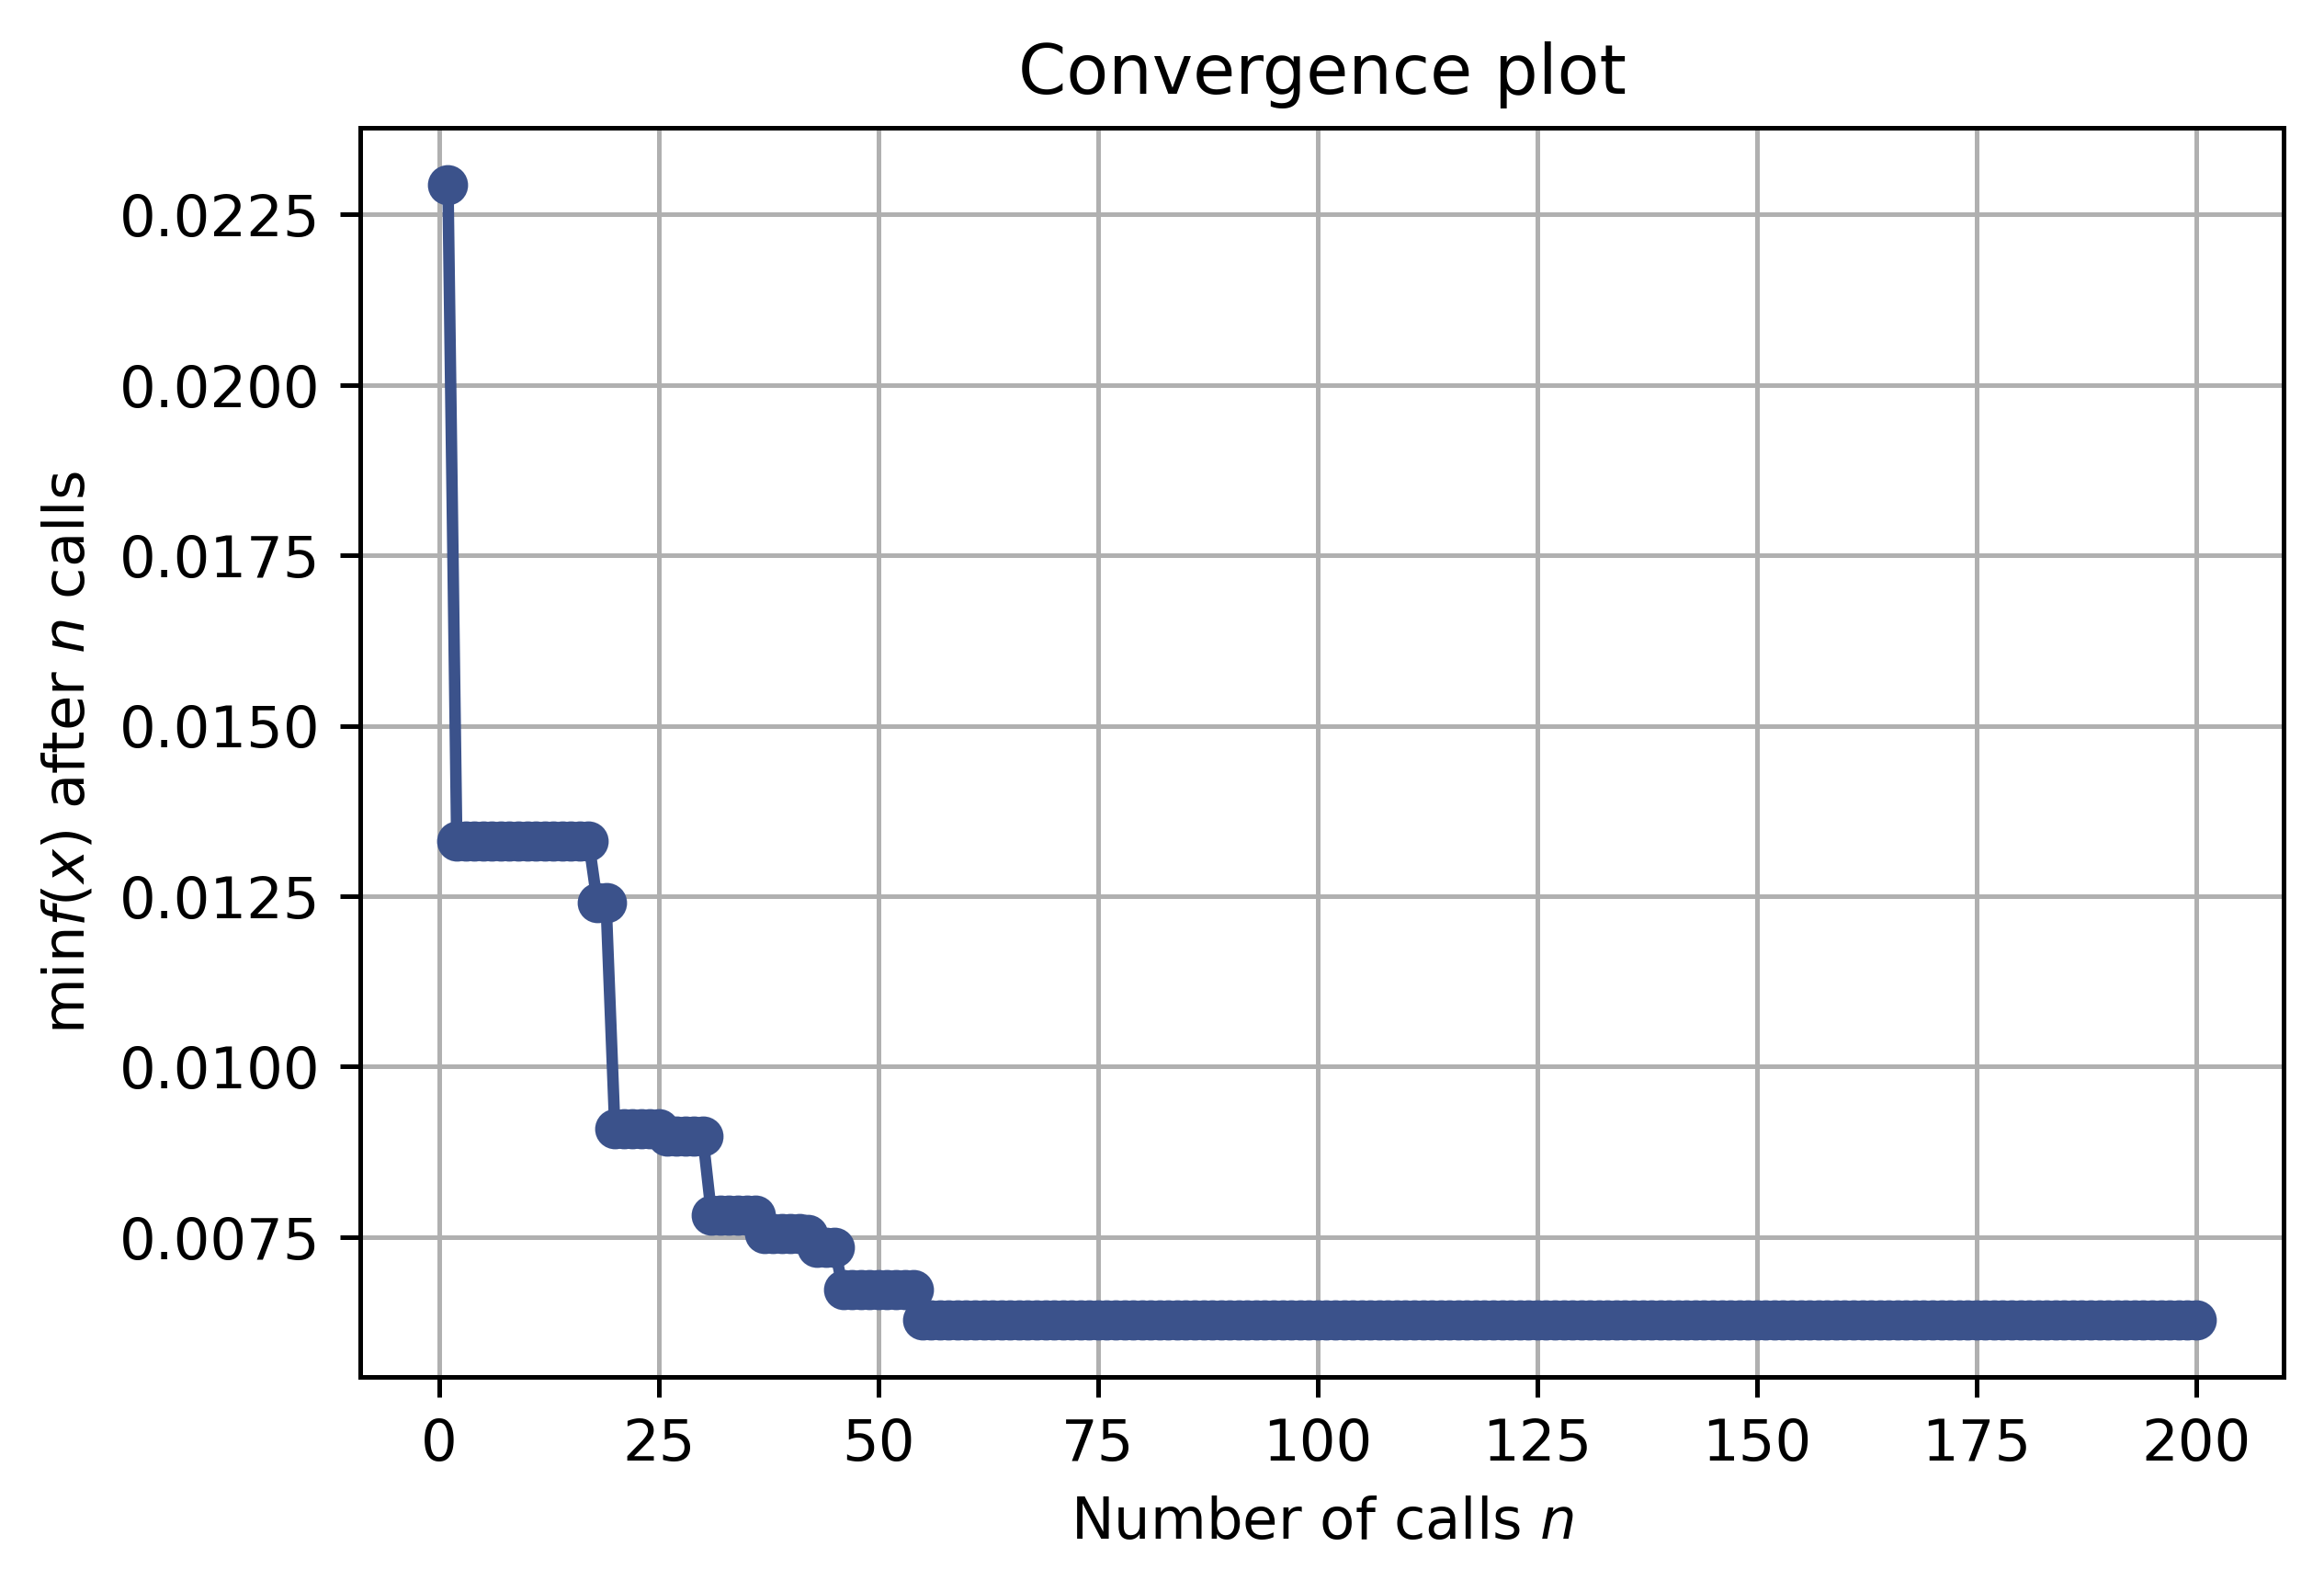

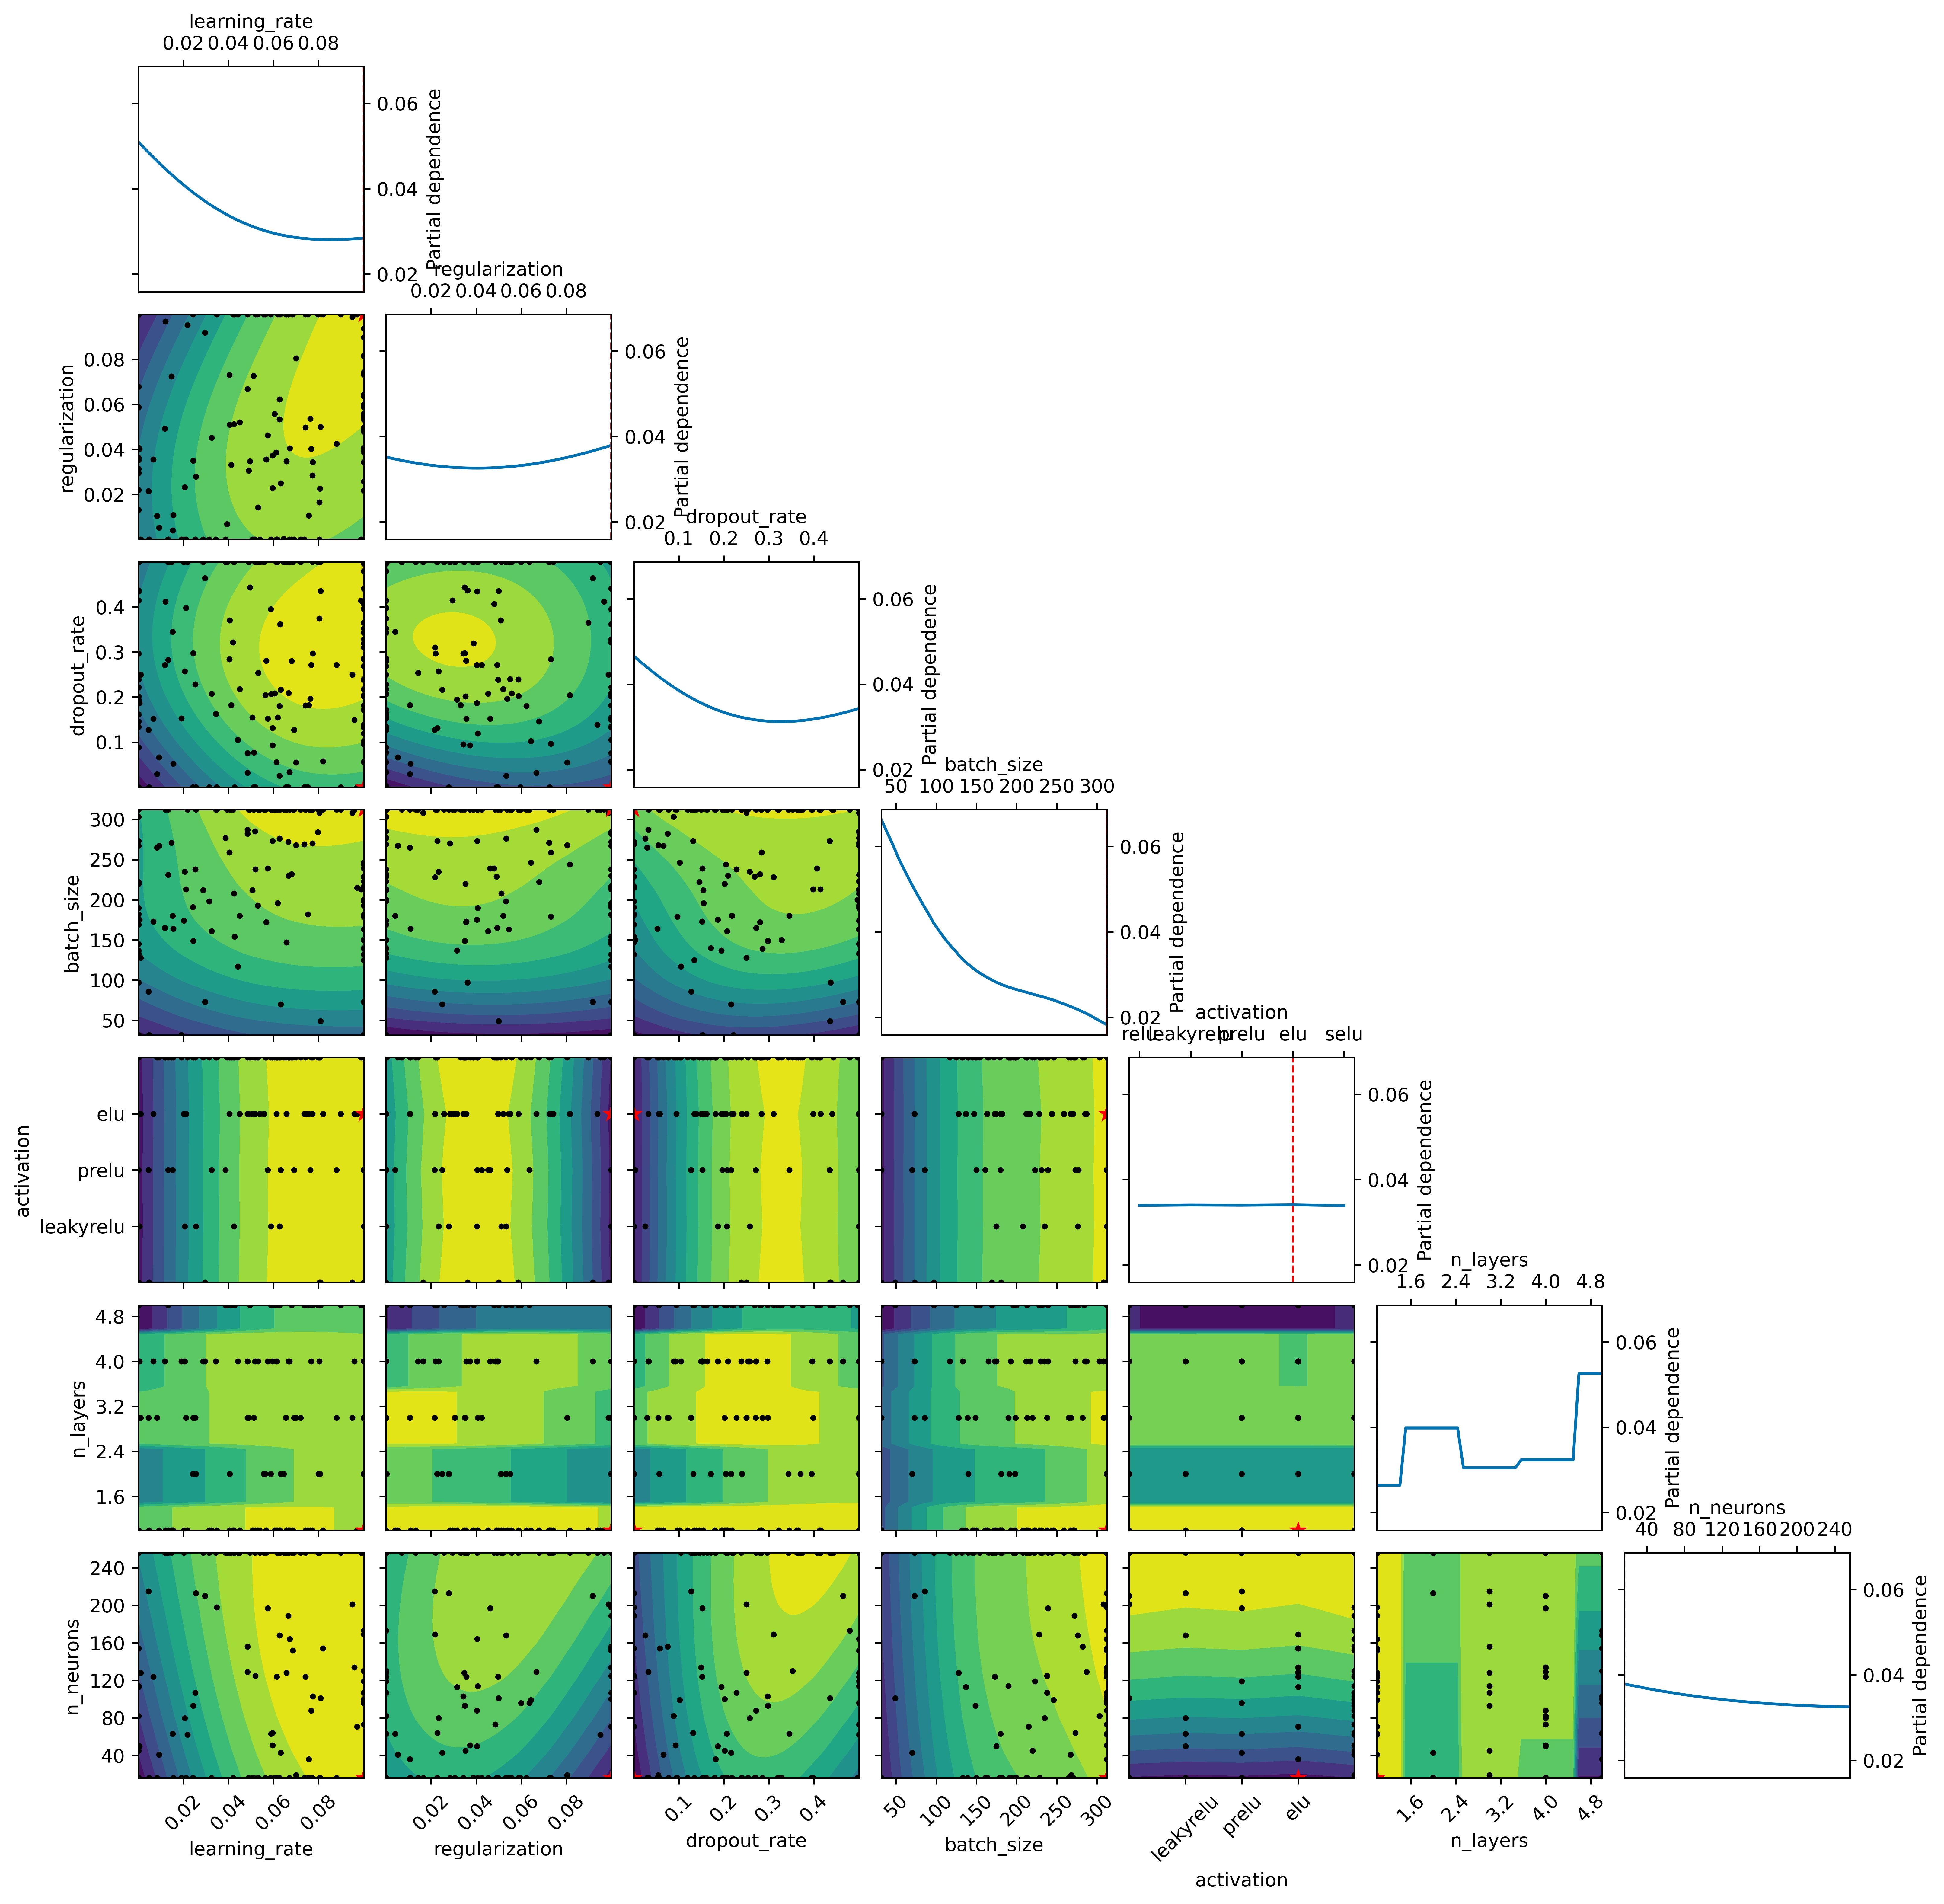

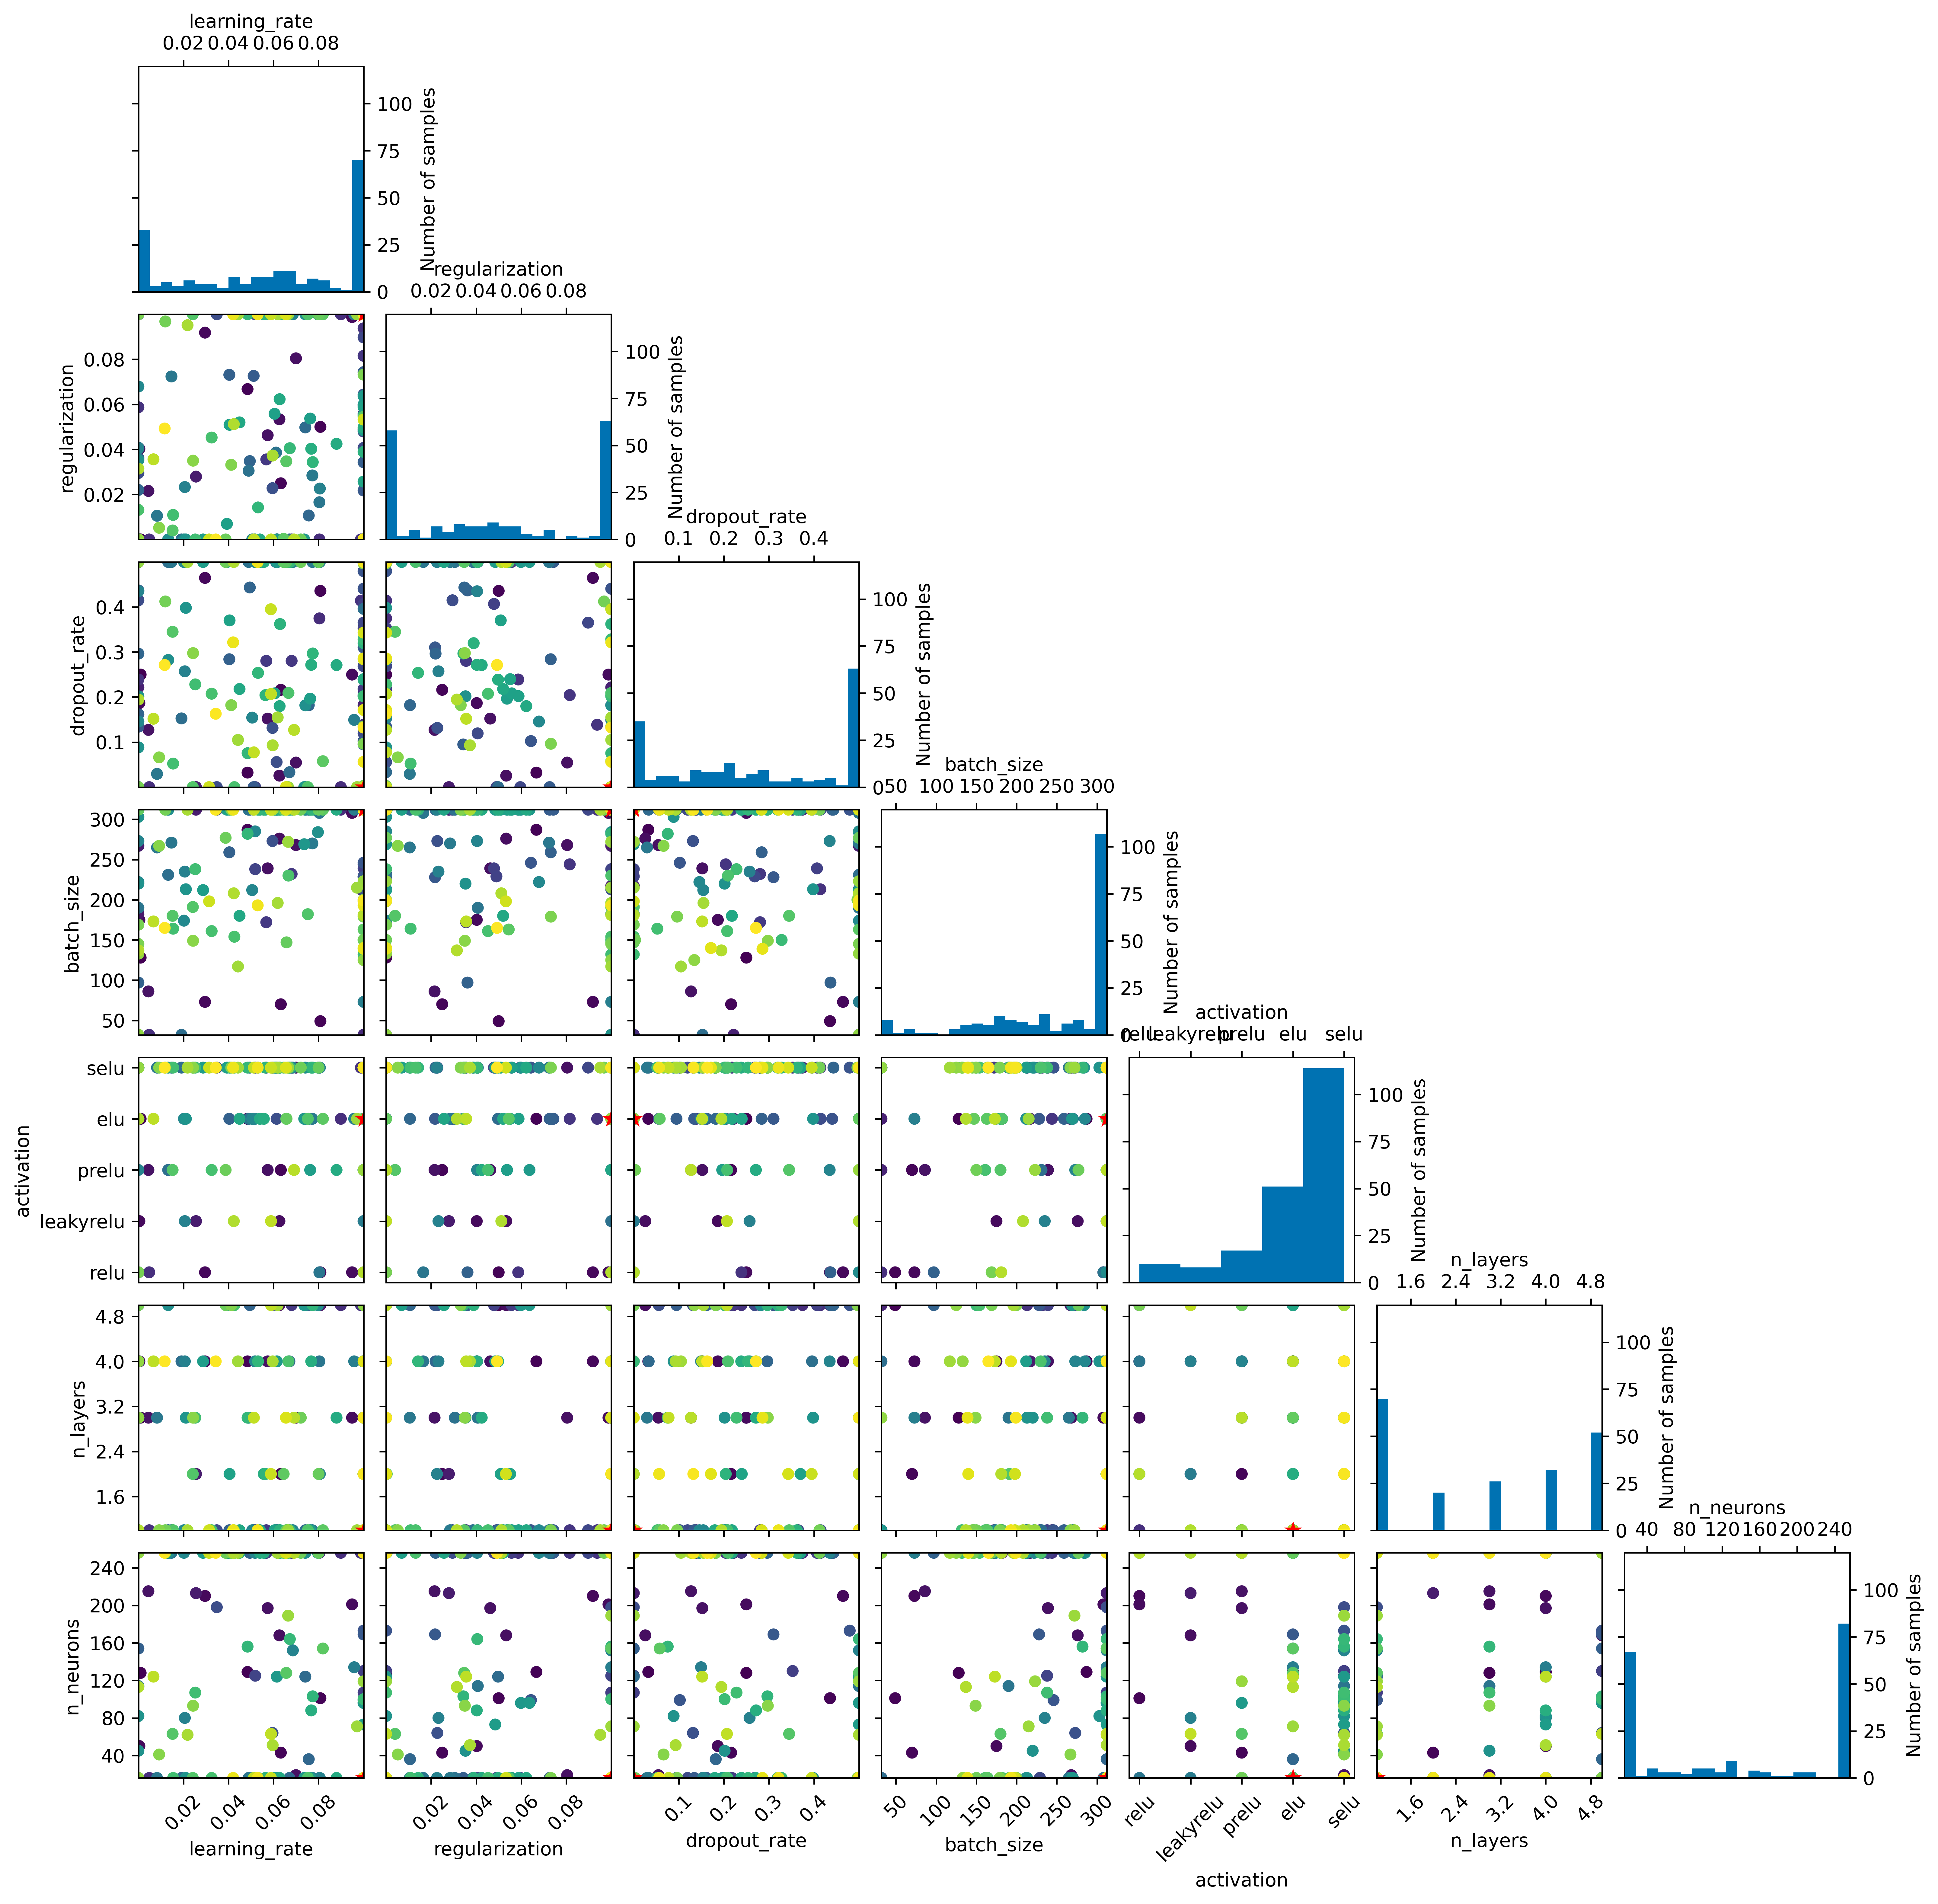

In [10]:
# ------------------- Bayesian optimization --------------------------------- #


class tqdm_skopt(object):
    """Progress bar object for functions with callbacks."""

    def __init__(self, **kwargs):
        self._bar = tqdm(**kwargs)

    def __call__(self, res):
        """Update bar with intermediate results."""
        self._bar.update()


# Set parameter search space
space = []
# space.append(Categorical(['relu', 'leakyrelu', 'elu'], name='activation'))
space.append(Real(1e-5, 1e-1, name='learning_rate'))
space.append(Real(1e-10, 1e-1, name='regularization'))
space.append(Real(0.0, 0.5, name='dropout_rate'))
space.append(Integer(int(32), int(312), name='batch_size', dtype=int))
space.append(Categorical(['relu', 'leakyrelu', 'prelu', 'elu', 'selu'], name='activation'))
space.append(Integer(int(1), int(5), name='n_layers', dtype=int))
space.append(Integer(int(16), int(256), name='n_neurons', dtype=int))

# Set default hyperparameters
default_params = [1e-3,
                  1e-5,
                  0.25,
                  128,
                  'elu',
                  3,
                  128]

# Work in progress
@use_named_args(dimensions=space)
def fitness(learning_rate, regularization, dropout_rate, batch_size, activation,
            n_layers, n_neurons):
    """Perform Bayesian Hyperparameter tuning."""

    if activation == 'relu':
        activation = nn.ReLU()
    elif activation == 'leakyrelu':
        activation = nn.LeakyReLU()
    elif activation == 'elu':
        activation = nn.ELU()
    elif activation == 'selu':
        activation = nn.SELU()
    elif activation == 'prelu':
        activation = nn.PReLU()

    # print(f'Learning Rate: {learning_rate:.0e}, Regularization: {regularization:.0e}, ', end='')
    # print(f'Dropout: {dropout:.2f}')  #, Batch Size: {batch_size}')

    model = NeuralNet(activation=activation, dropout_rate=dropout_rate,
                      n_layers=n_layers, n_neurons=n_neurons)
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate,
                                                weight_decay=regularization)
    # Create k-fold cross validation
    avg_best_loss, *_ = kfold_cv_train(x_train=x_train, y_train=y_train,
                                     model=model, optimizer=optimizer,
                                     batch_size=batch_size, patience=50)
    # print(f'Avg. best validation loss: {avg_best_loss}')

    return avg_best_loss

n_calls = 200
# Hyperparemeter search using Gaussian process minimization
gp_result = gp_minimize(func=fitness,
                        x0=default_params,
                        dimensions=space,
                        n_calls=n_calls,
                        verbose=True, callback=[tqdm_skopt(total=n_calls,
                                          desc='Gaussian Process')])

plot_convergence(gp_result)
plot_objective(gp_result)
plot_evaluations(gp_result)
gp_result.x